<a href="https://colab.research.google.com/github/Dreadnought73/AI_projects/blob/main/Time_series_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Sales SARIMA

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Coding_data_files/Forecasting_sales.csv')
df.head()

Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156  08/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688  12/06/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Category Sub-Category  \
0      42420.0  South  FUR-BO-10001798        Furniture    Bookcases   
1      42420.0  South  FUR-CH-10000454        Furniture       Chairs   
2      90036.0   West  OFF-LA-10000240  Office Supplies       Labels   
3      33311.0  South  FUR-TA-10000577        Furniture       Tables   
4      33311.0  South  OFF-ST-10000760  Office Supplies      Storage   

                                        Product Name     Sales  
0                  Bush Somerset Collection Bookcase  261.9600  
1  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4                     Eldon Fold 'N Roll Cart System   22.3680

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

In [ ]:
df.isnull().sum()

Row ID            0
Order ID          0
Order Date        0
Ship Date         0
Ship Mode         0
Customer ID       0
Customer Name     0
Segment           0
Country           0
City              0
State             0
Postal Code      11
Region            0
Product ID        0
Category          0
Sub-Category      0
Product Name      0
Sales             0
dtype: int64

# EDA

In [ ]:
df.drop('Row ID',axis = 1, inplace = True)
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d/%m/%Y')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], format='%d/%m/%Y')

In [ ]:
df['Sub-Category'].value_counts().sort_values(ascending=False)

Sub-Category
Binders        1492
Paper          1338
Furnishings     931
Phones          876
Storage         832
Art             785
Accessories     756
Chairs          607
Appliances      459
Labels          357
Tables          314
Envelopes       248
Bookcases       226
Fasteners       214
Supplies        184
Machines        115
Copiers          66
Name: count, dtype: int64

In [ ]:
categories = df['Sub-Category'].unique()
categories.sort()
df['Year_Month_Order'] = df['Order Date'].dt.strftime('%Y-%m')
df['Year_Order'] = df['Order Date'].dt.strftime('%Y')

Find out the number of sales per year for each sub-category product.

In [ ]:
sales_counts = df.groupby(['Sub-Category', 'Year_Order']).size().reset_index(name='Number of Sales')
sales_counts.head()

Sub-Category Year_Order  Number of Sales
0  Accessories       2015              141
1  Accessories       2016              165
2  Accessories       2017              184
3  Accessories       2018              266
4   Appliances       2015               92

Showing the changes using a lineplot. Most of them (if not all) have increasing sales rate to 2018, some of them have fluctuations.

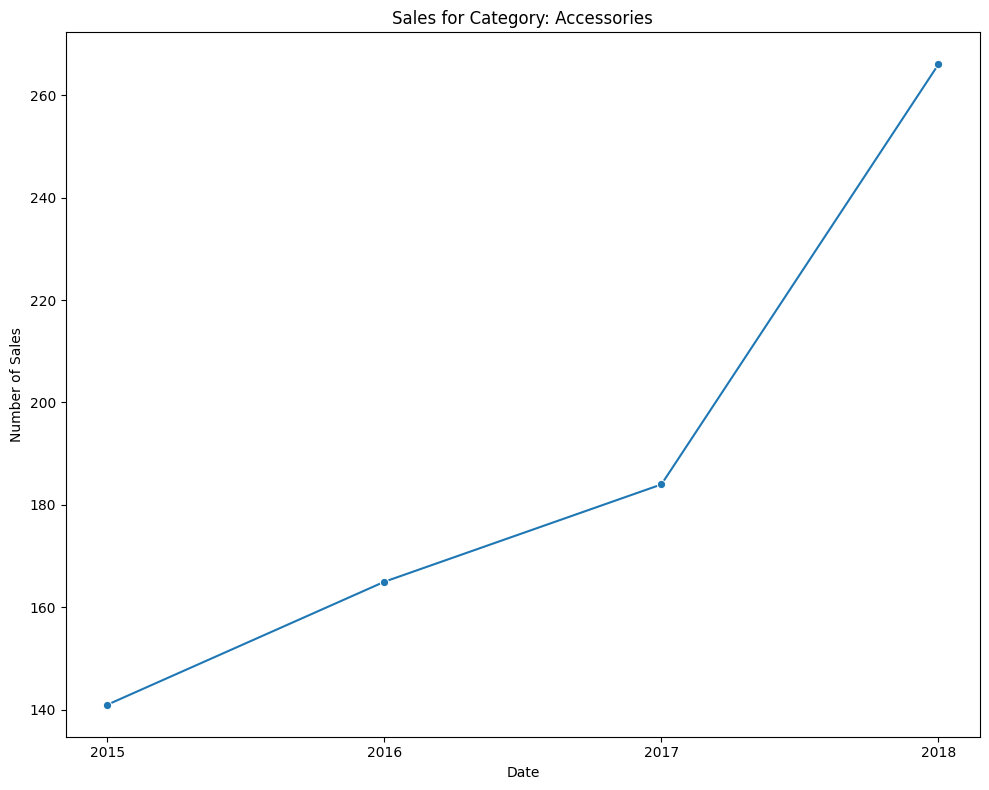

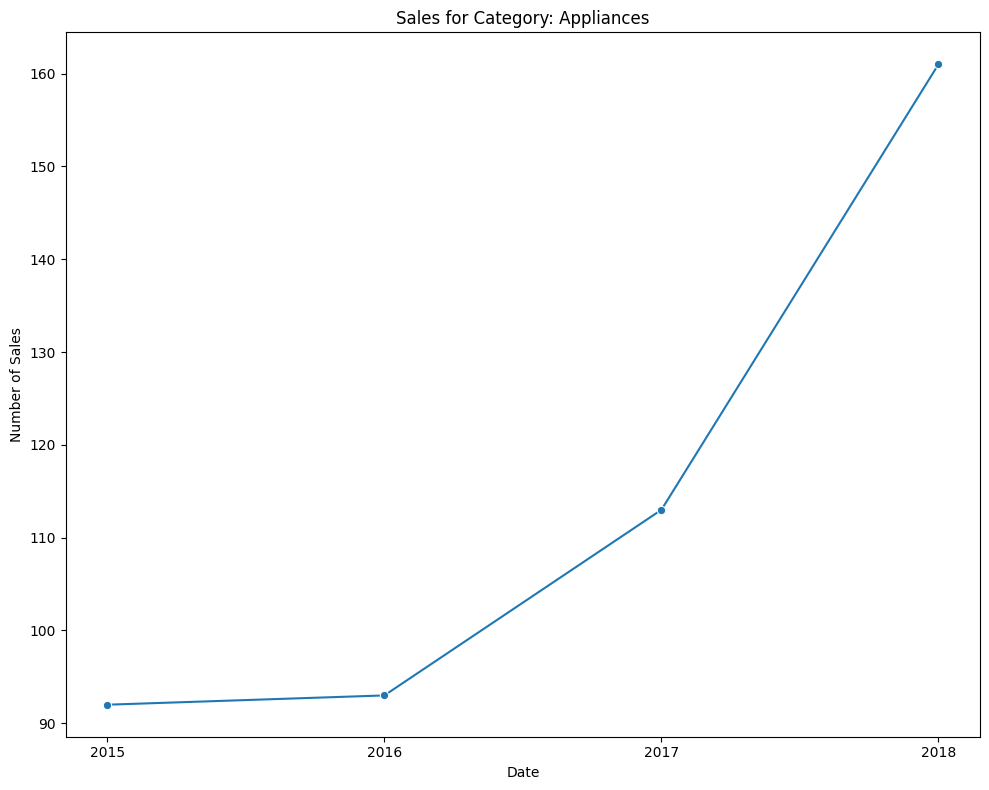

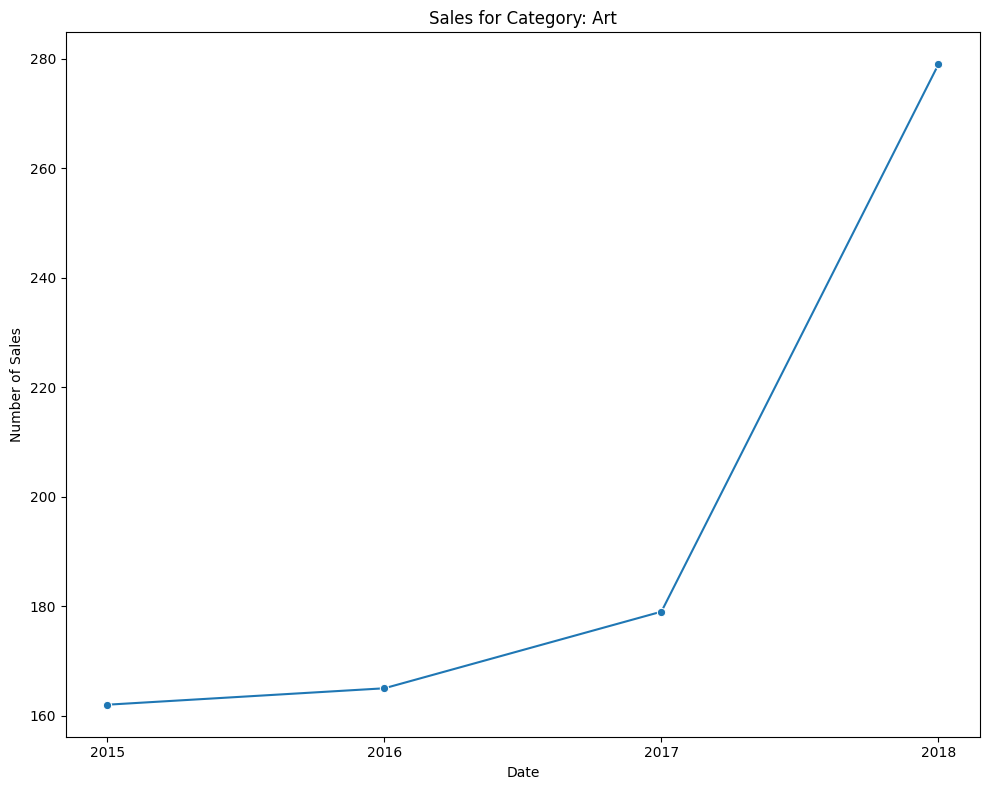

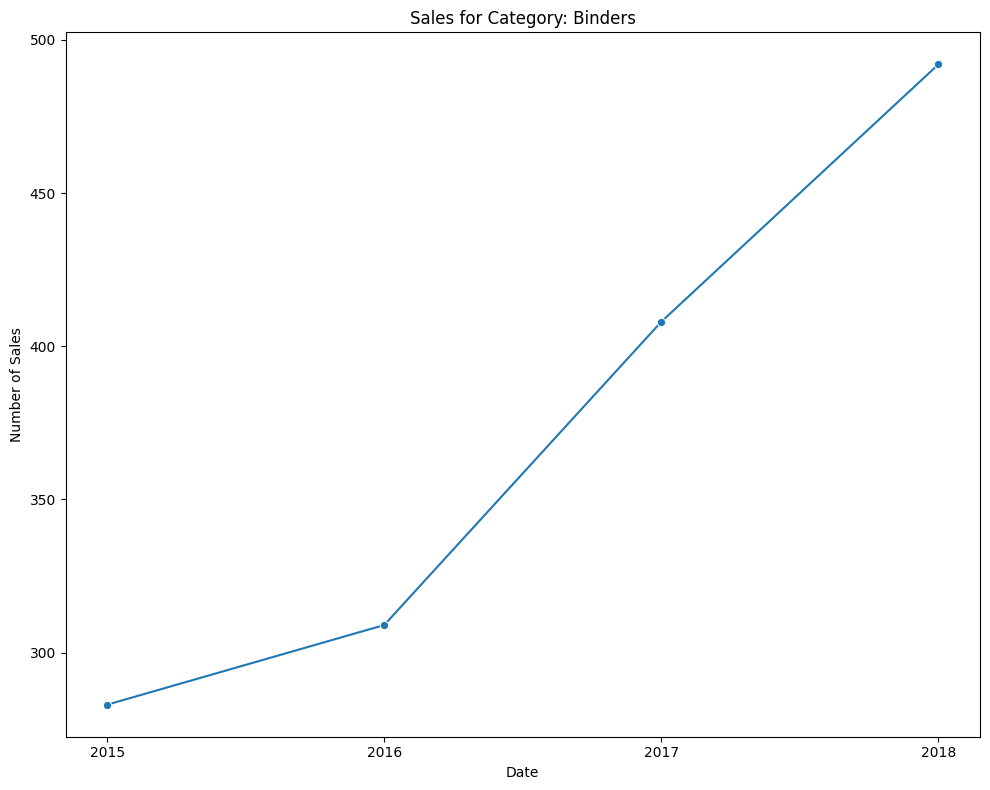

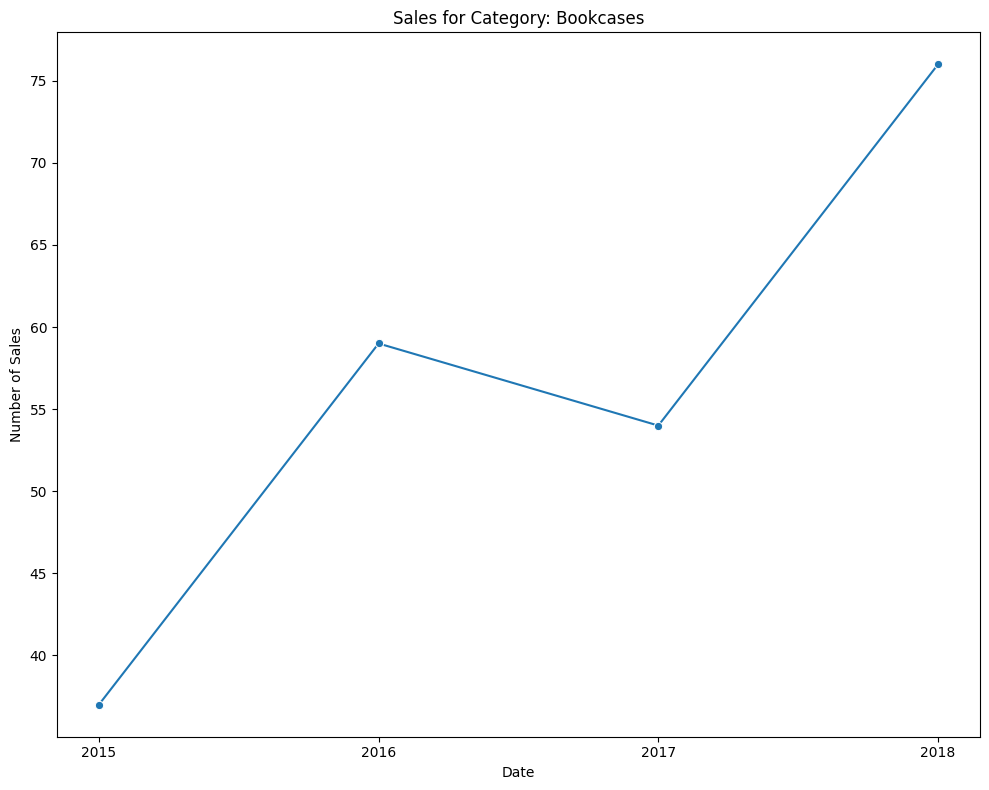

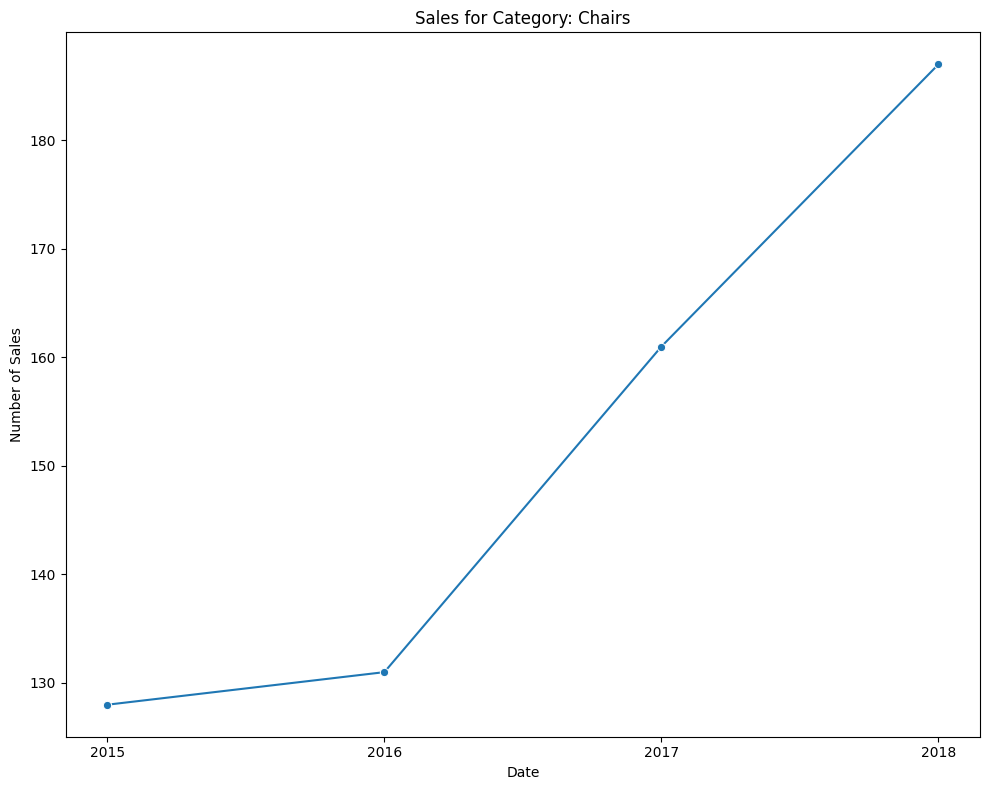

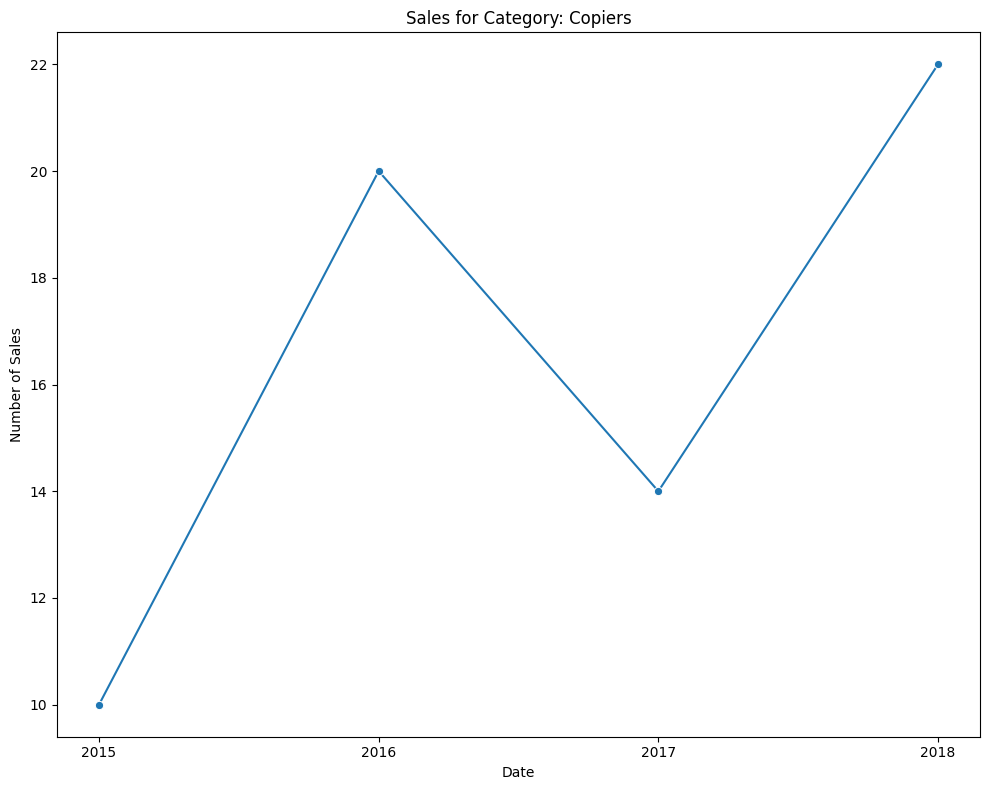

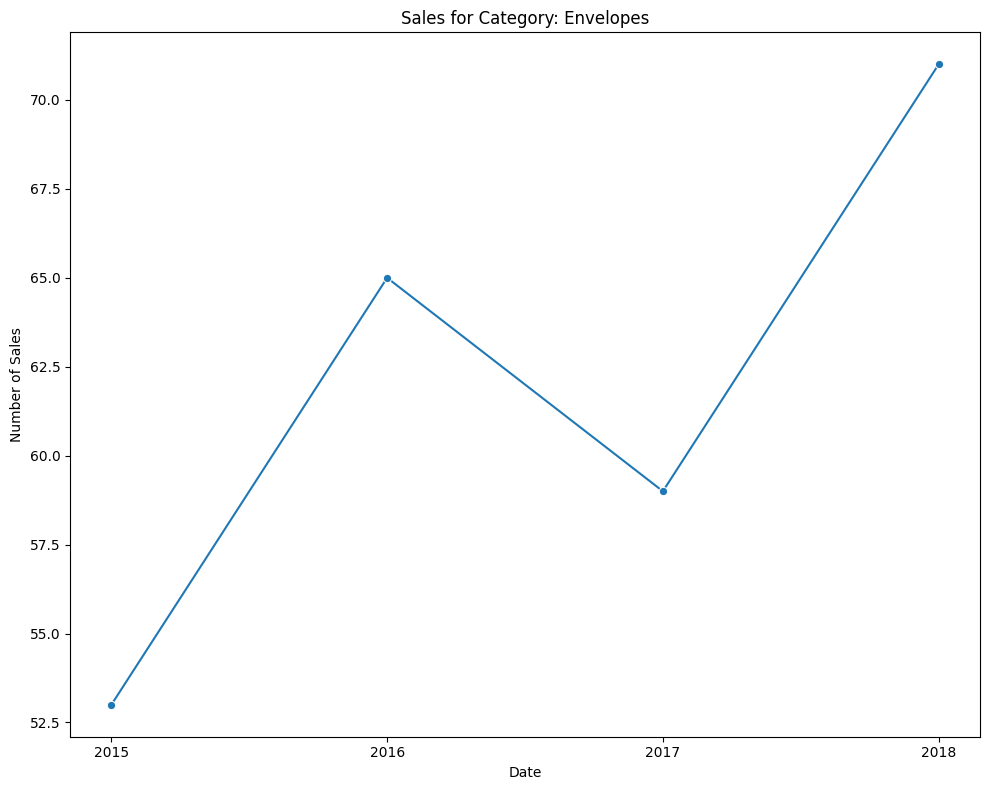

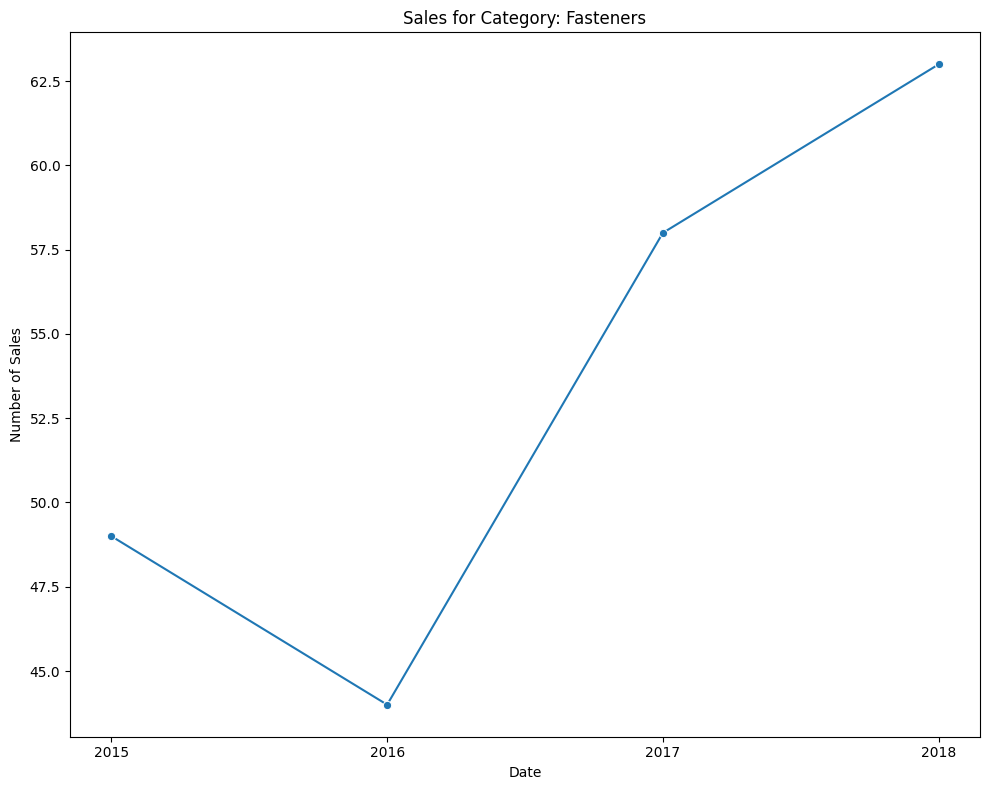

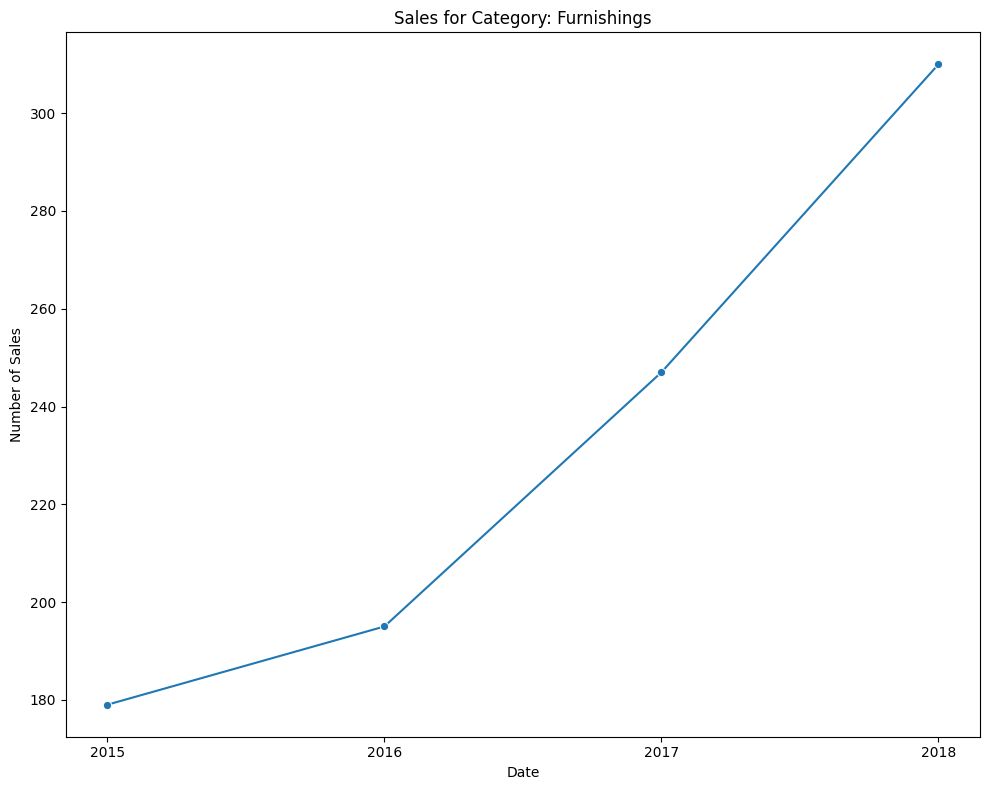

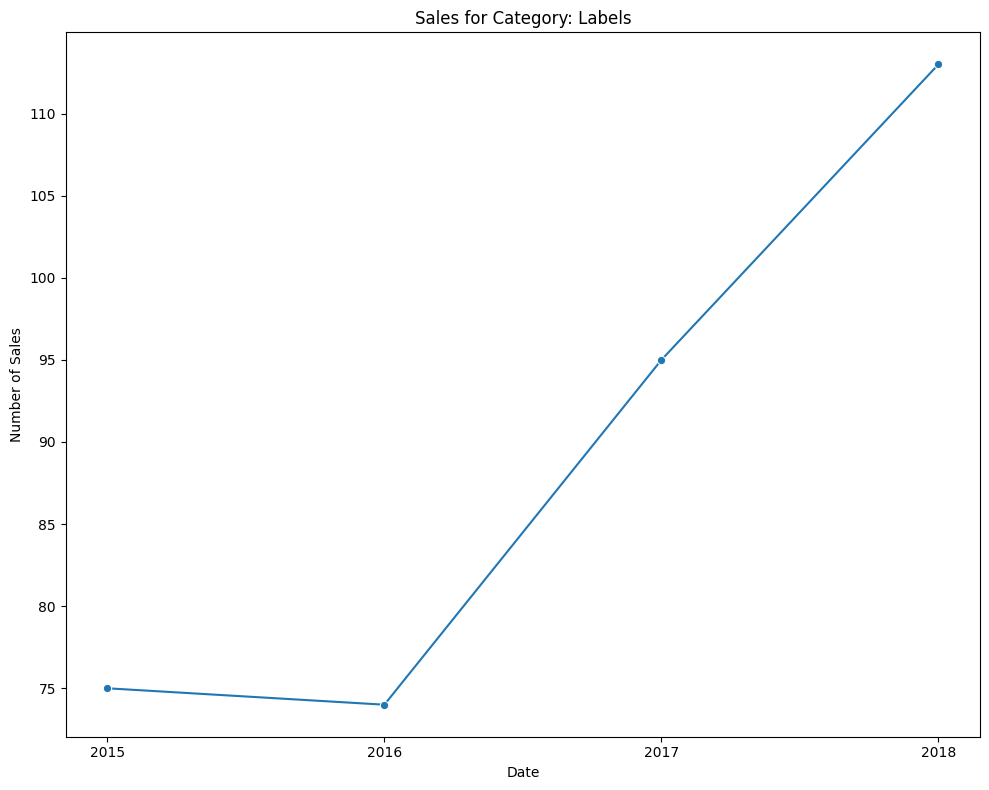

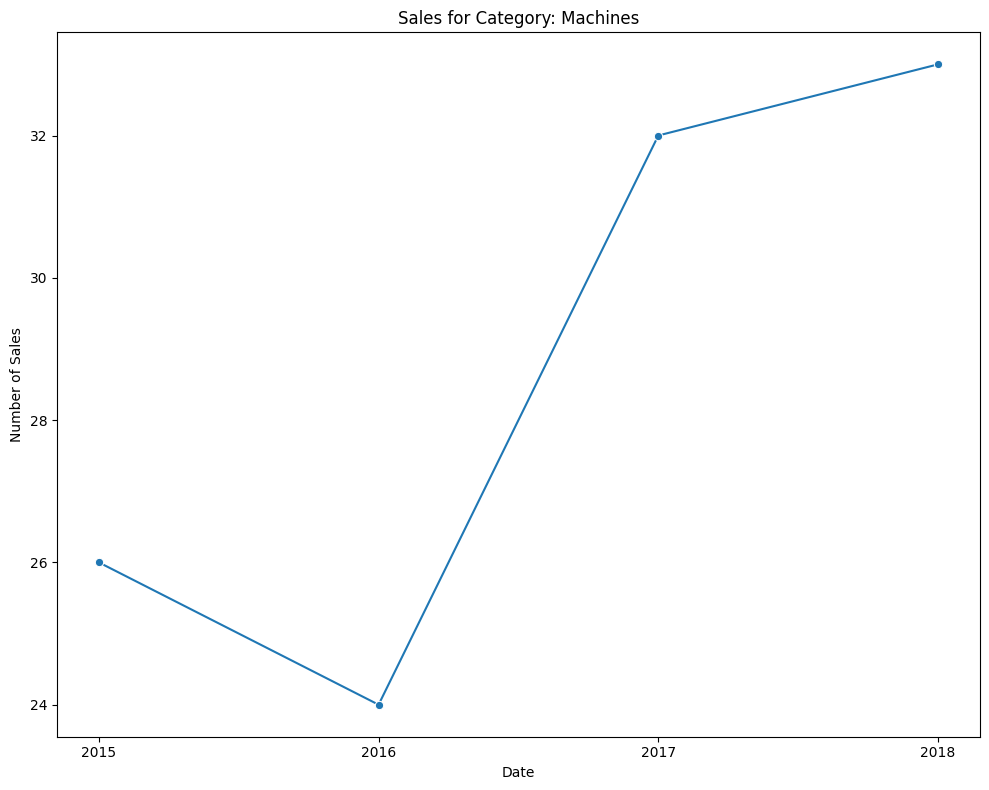

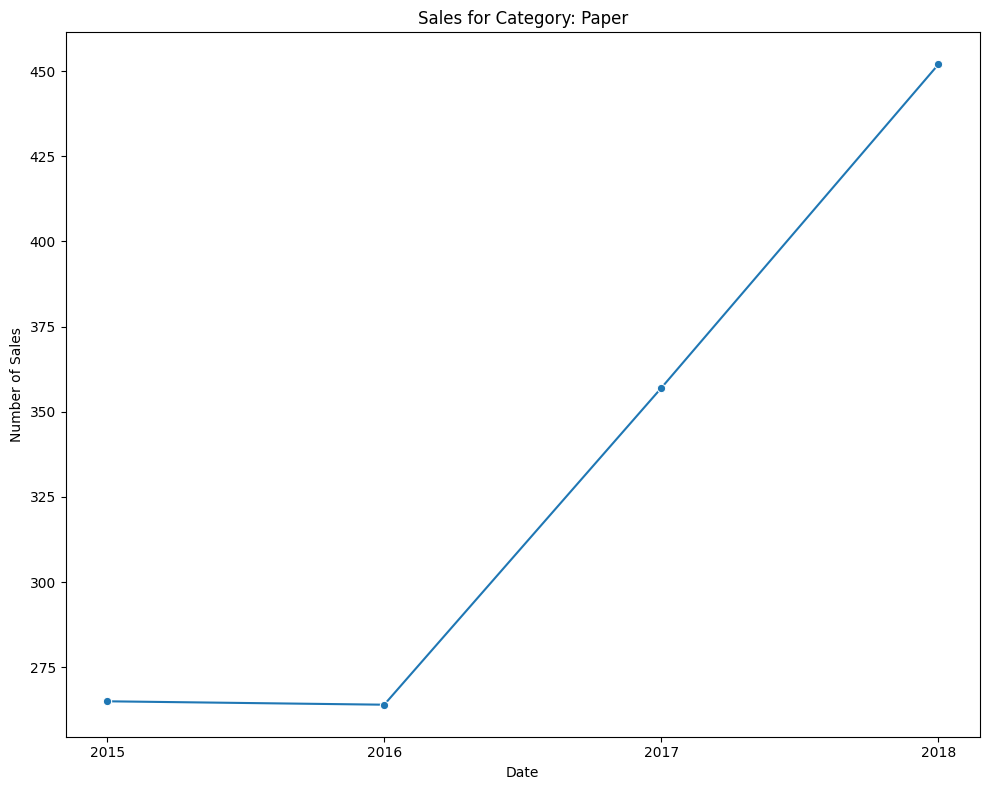

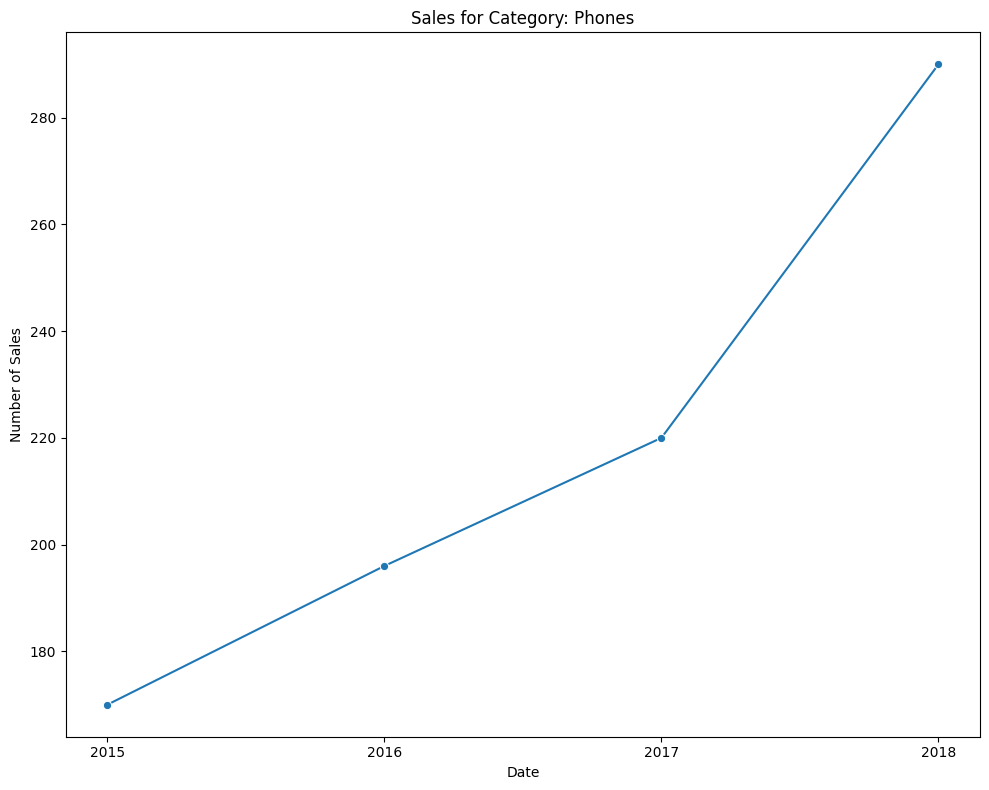

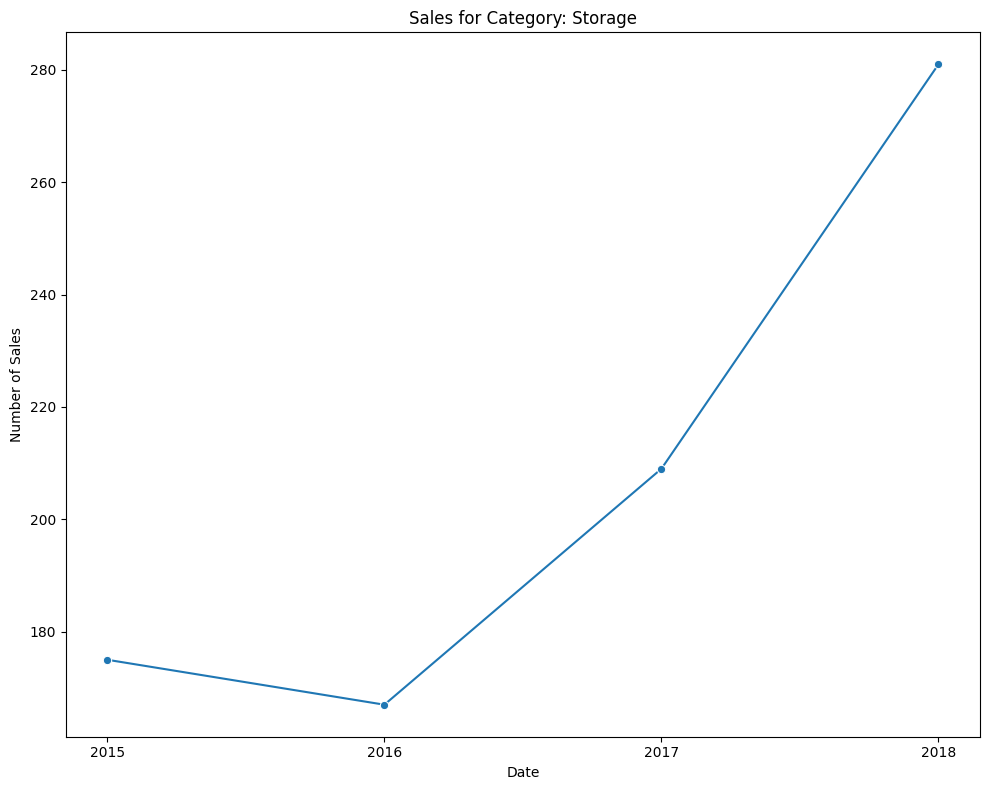

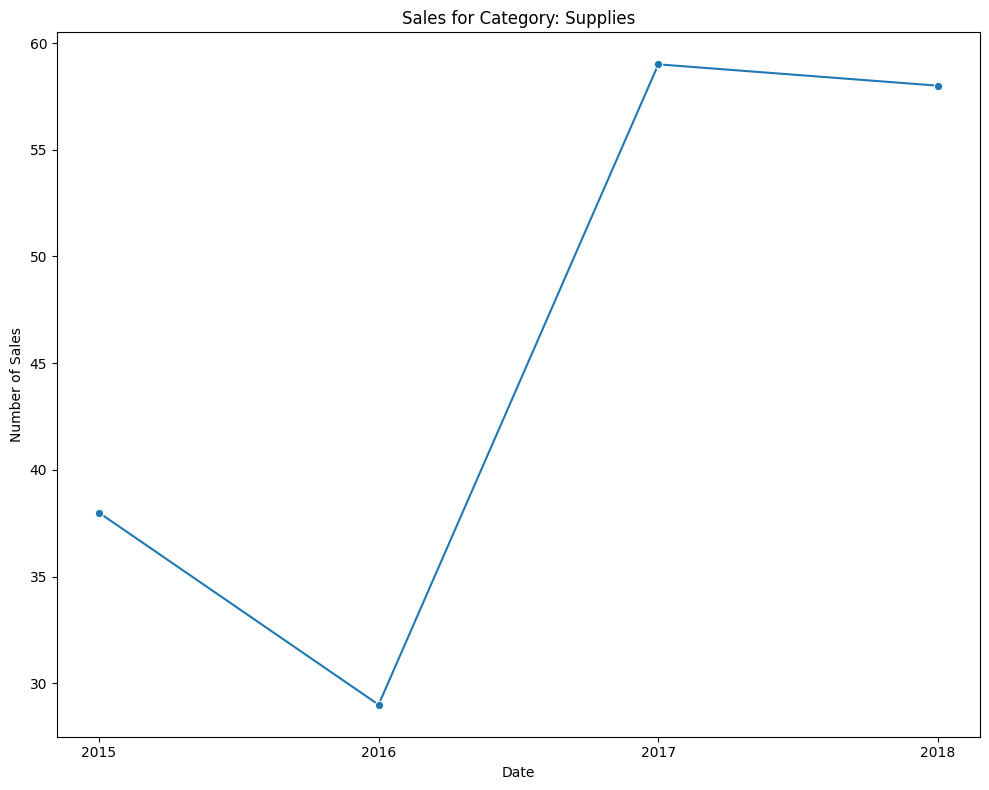

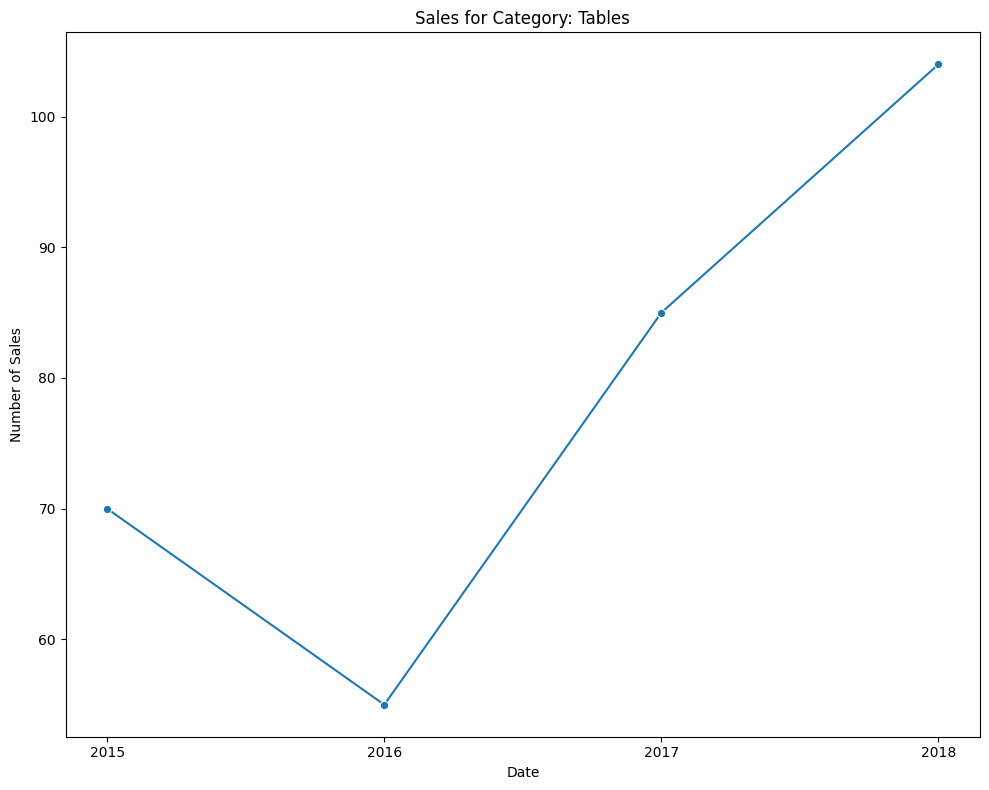

In [ ]:
for category in categories:
  category_df = sales_counts[sales_counts['Sub-Category'] == category]
  plt.figure(figsize=(10,8))
  sns.lineplot(data=category_df, x='Year_Order', y='Number of Sales', marker='o')
  plt.title(f'Sales for Category: {category}')
  plt.xlabel('Date')
  plt.ylabel('Number of Sales')
  plt.tight_layout()
  plt.show()

Categorizing the sales by each month in each year.

In [ ]:
# separate the years by months
sales_by_months = df.groupby(['Sub-Category', 'Year_Order', 'Year_Month_Order']).size().reset_index(name='Number of Sales')
sales_by_months.head()

Sub-Category Year_Order Year_Month_Order  Number of Sales
0  Accessories       2015          2015-01                3
1  Accessories       2015          2015-02                5
2  Accessories       2015          2015-03                7
3  Accessories       2015          2015-04               11
4  Accessories       2015          2015-05                9

In [ ]:
years = df['Year_Order'].unique()
years.sort()

Showing the changes using a lineplot. Most of them goes down at December and towards November, with fluctuations, it goes up.

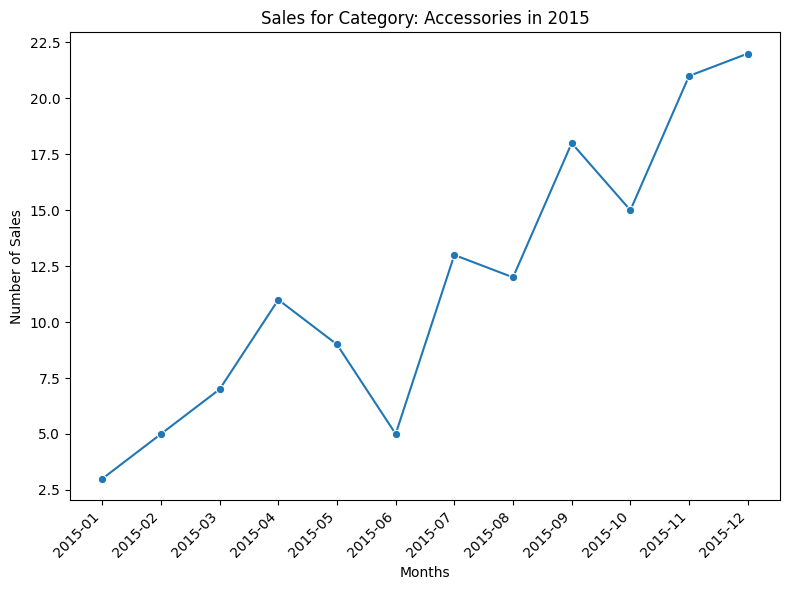

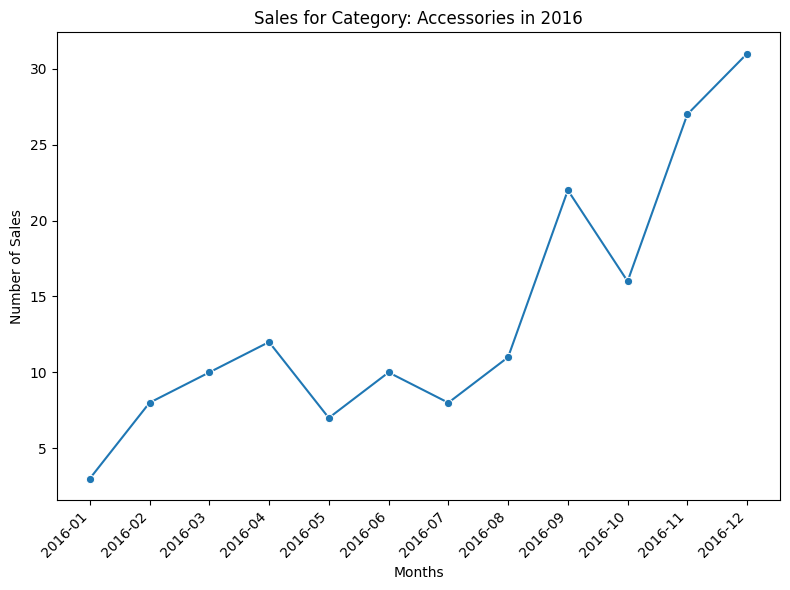

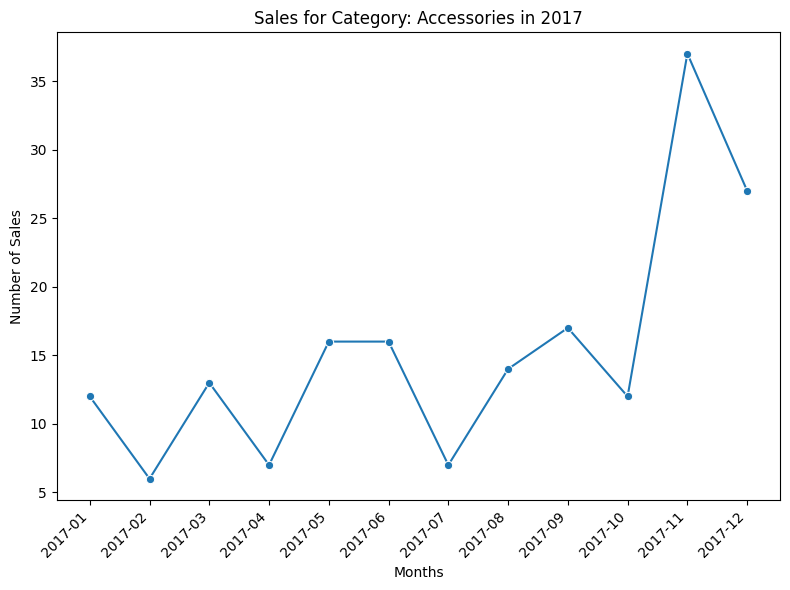

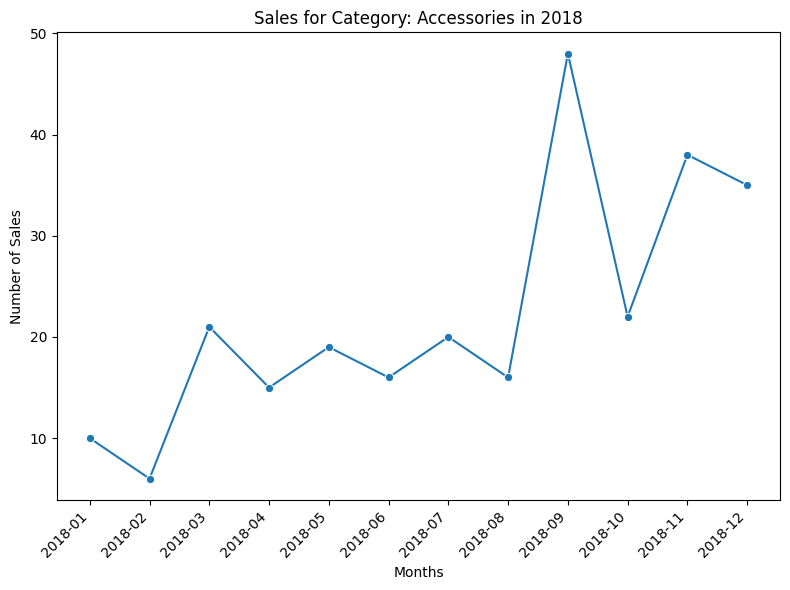

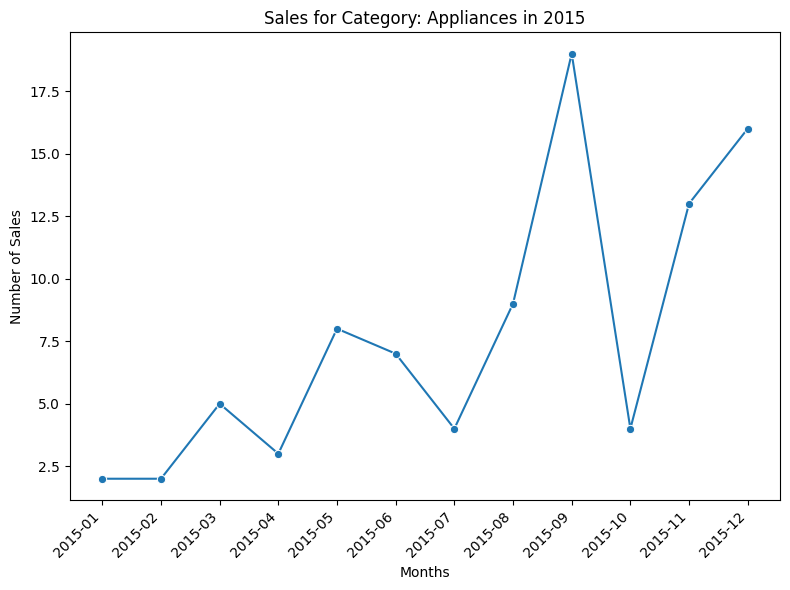

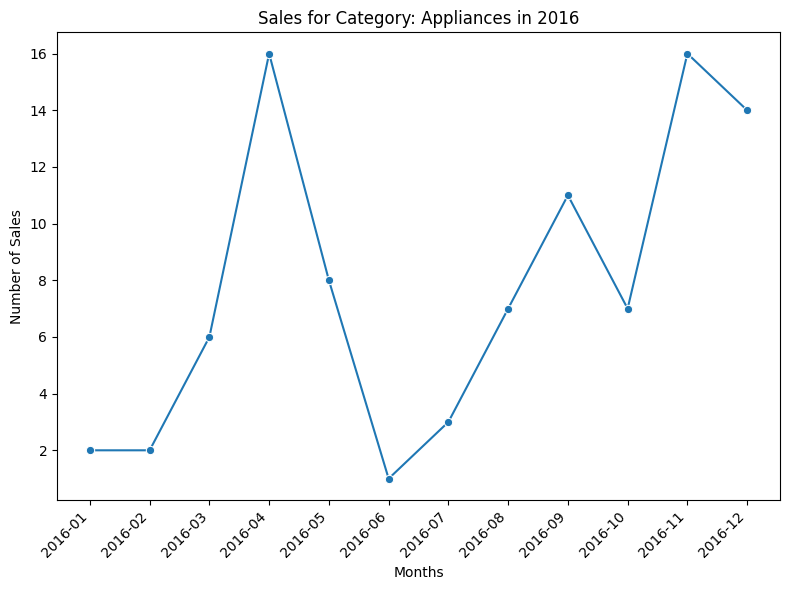

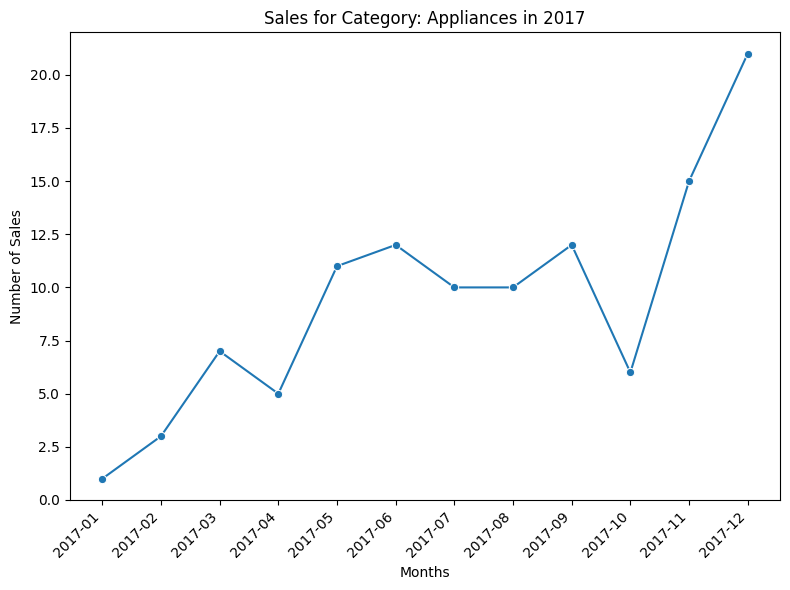

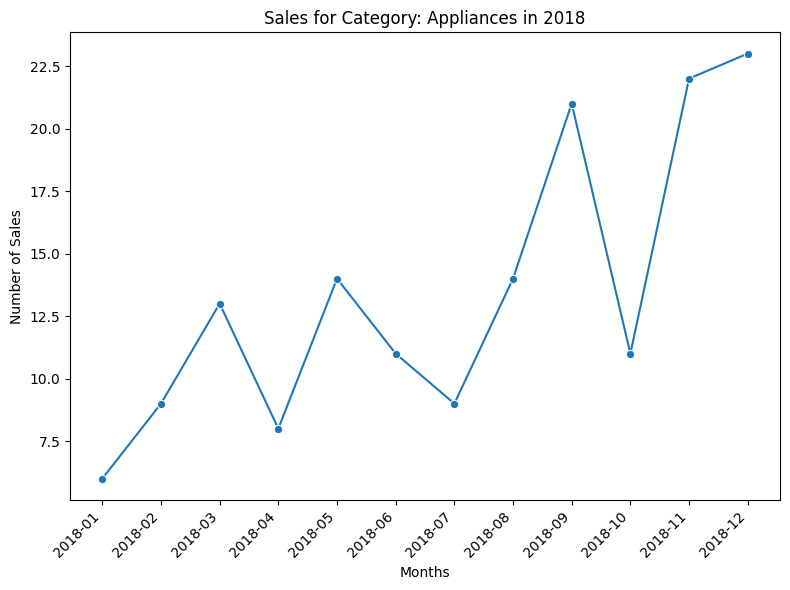

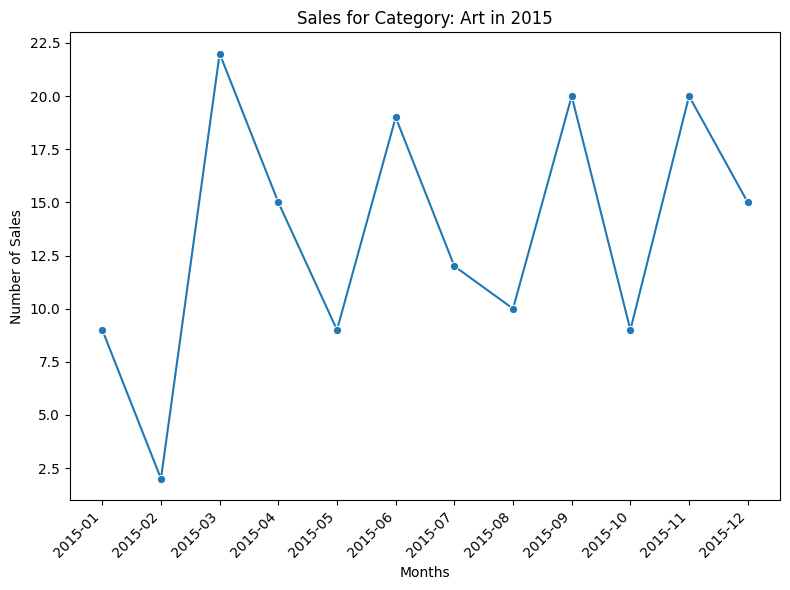

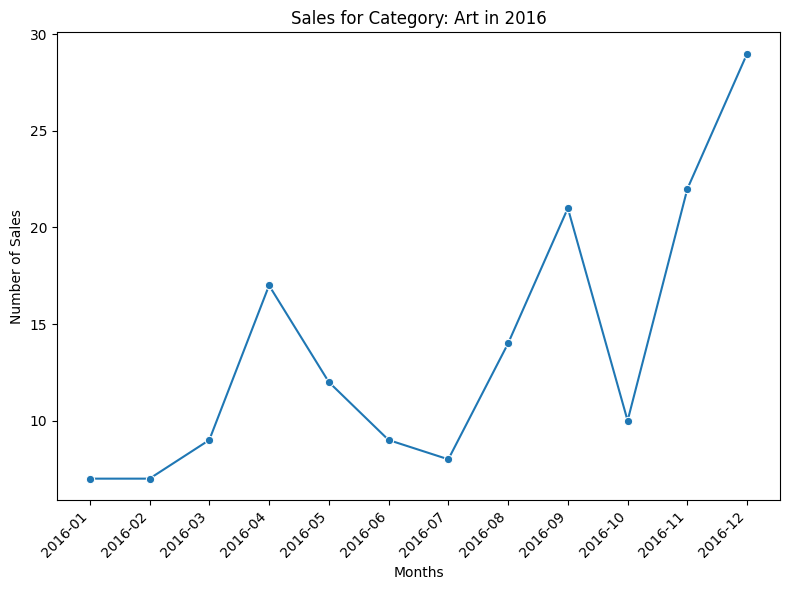

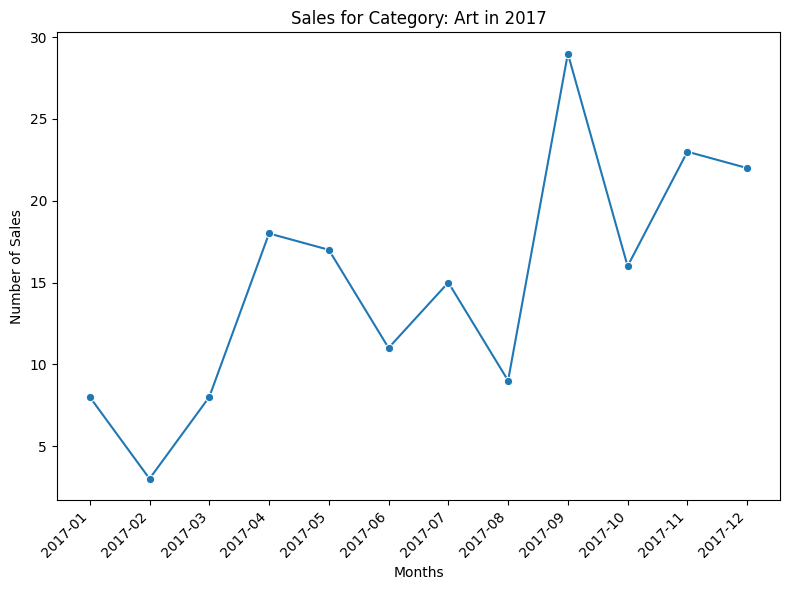

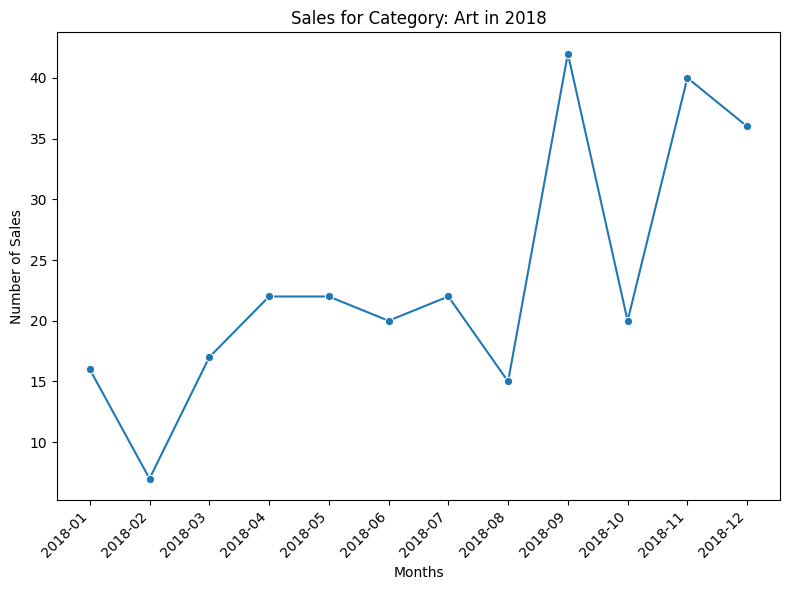

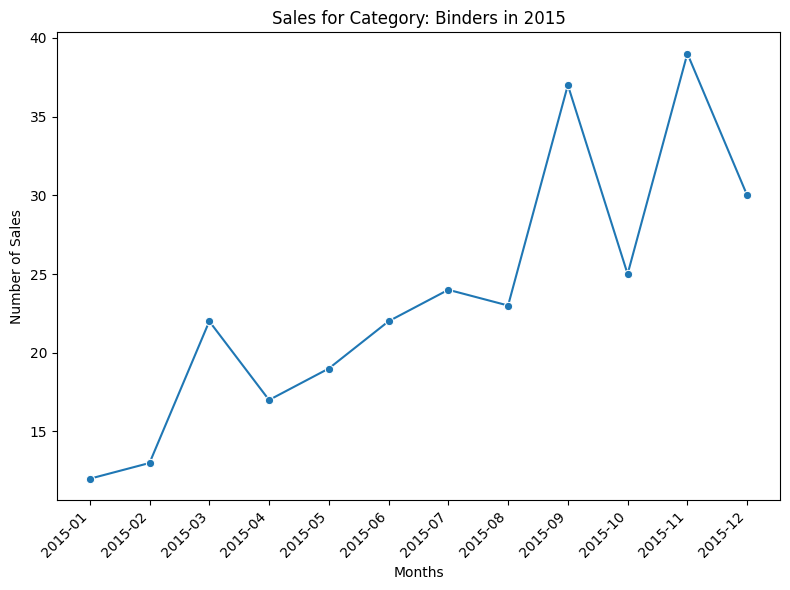

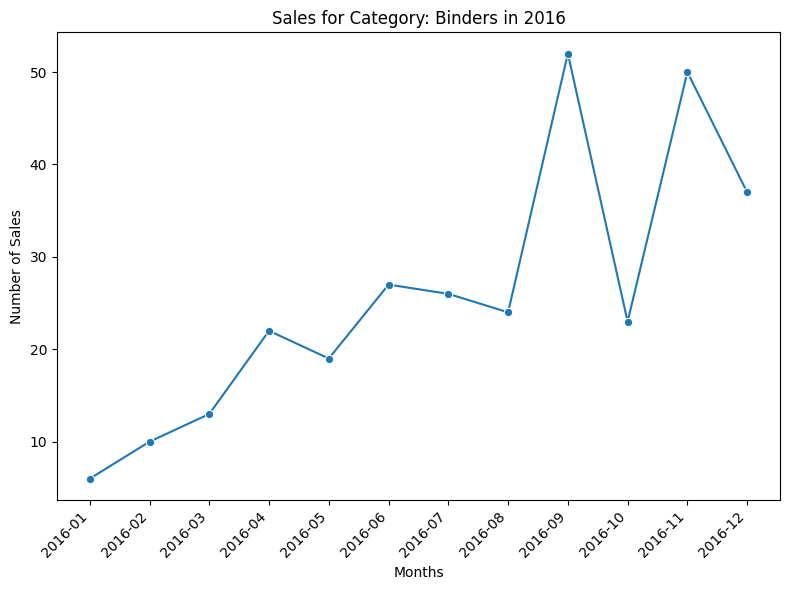

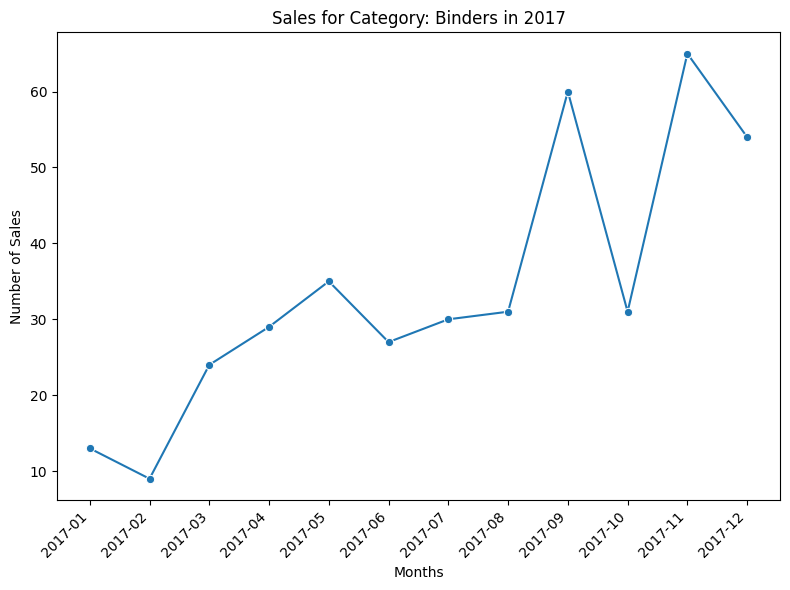

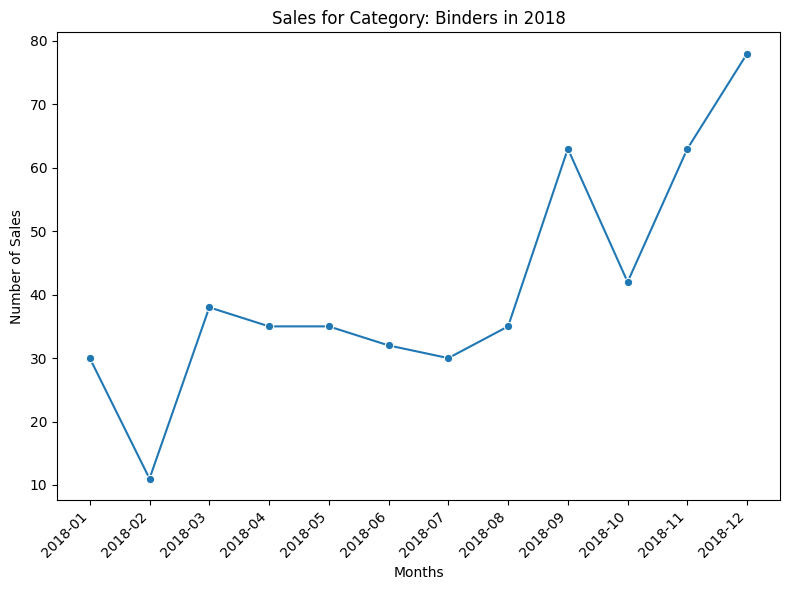

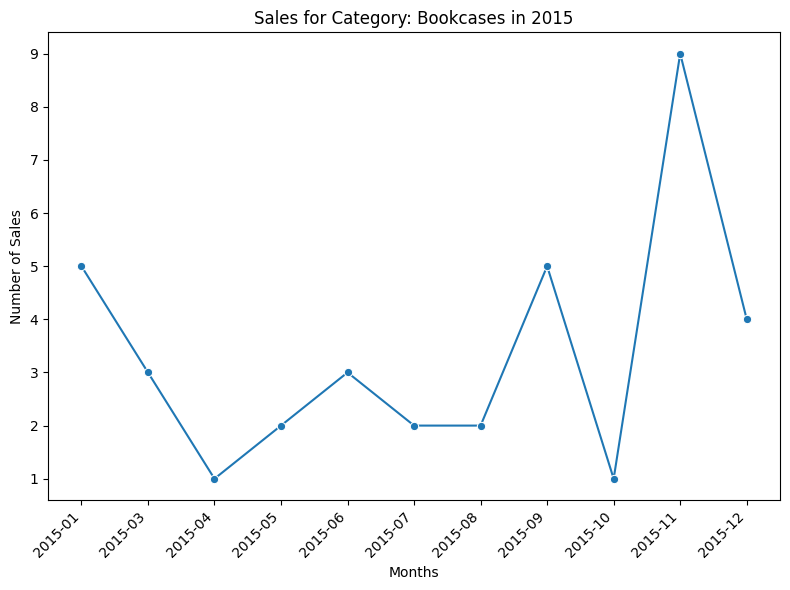

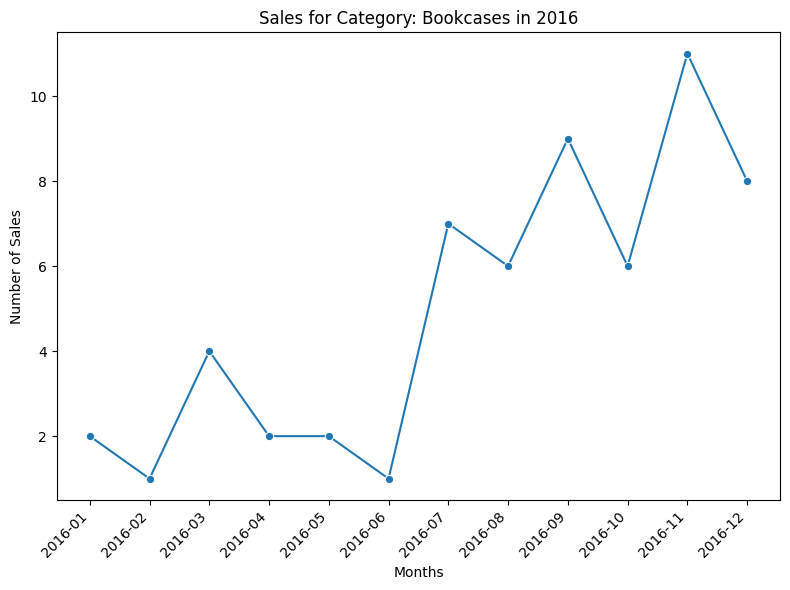

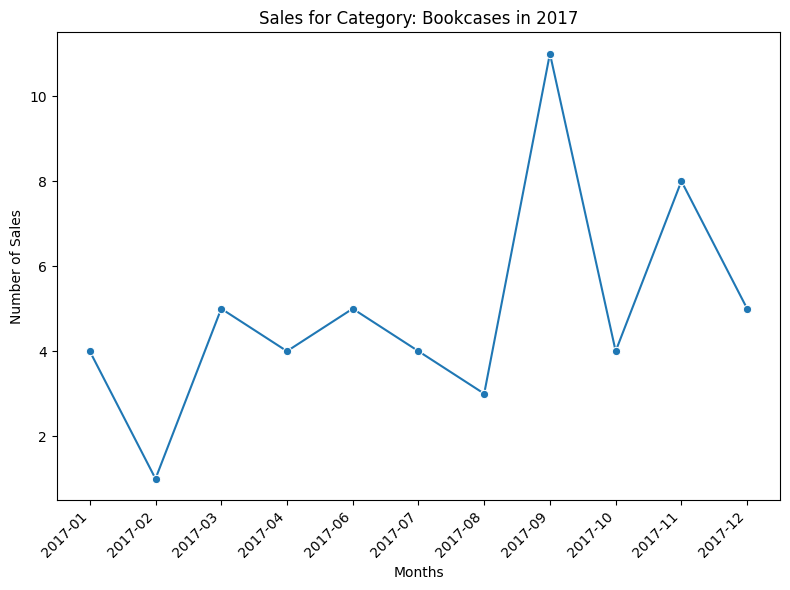

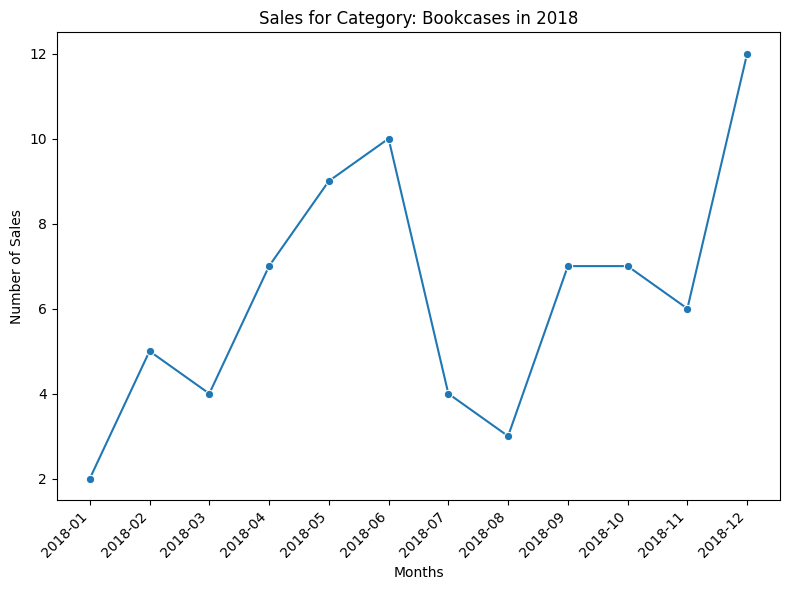

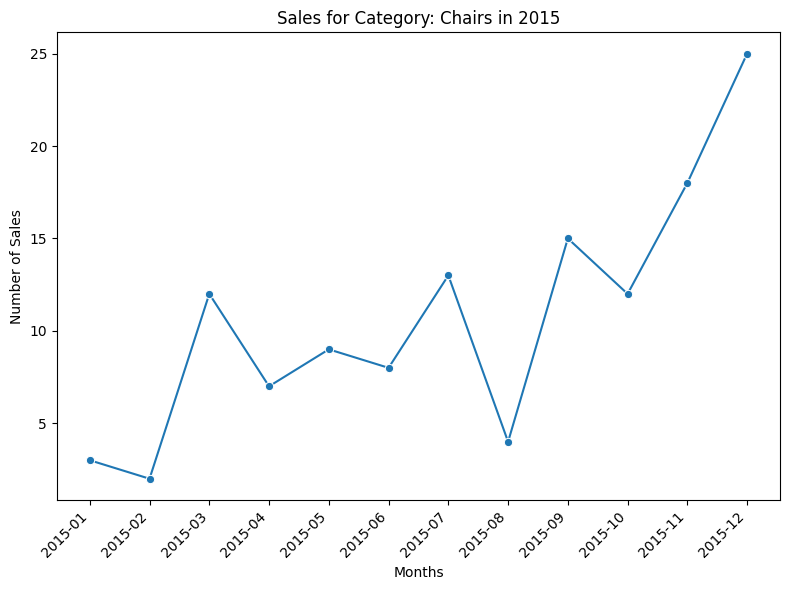

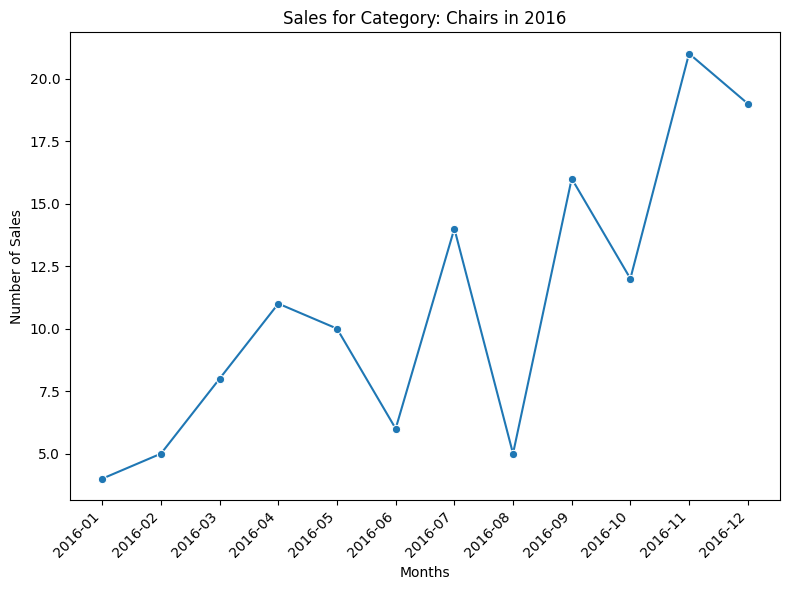

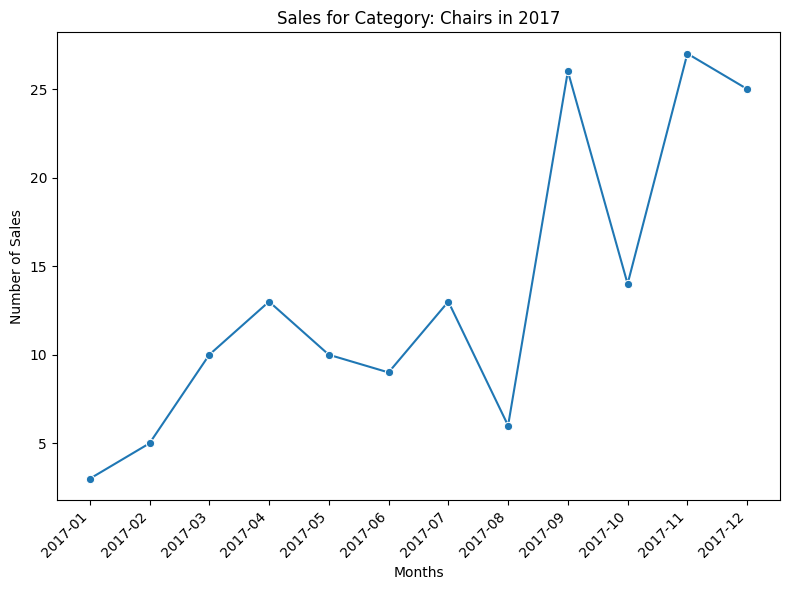

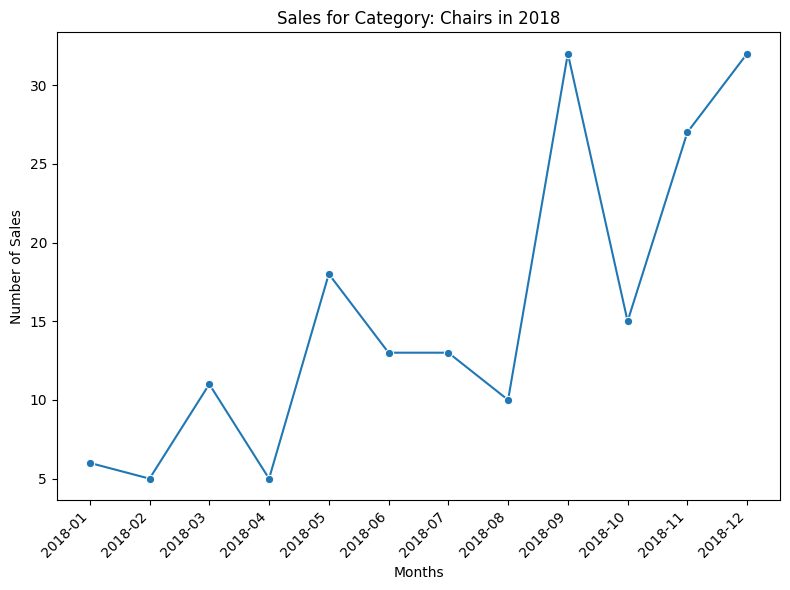

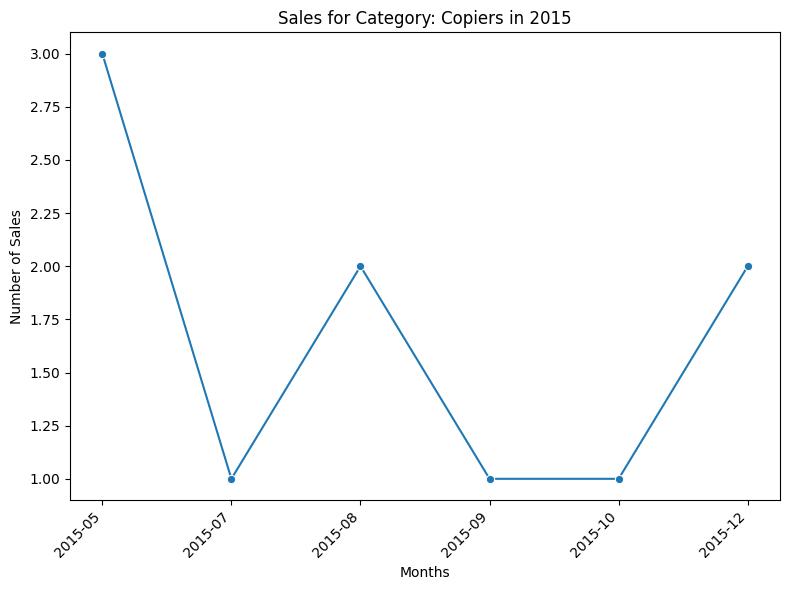

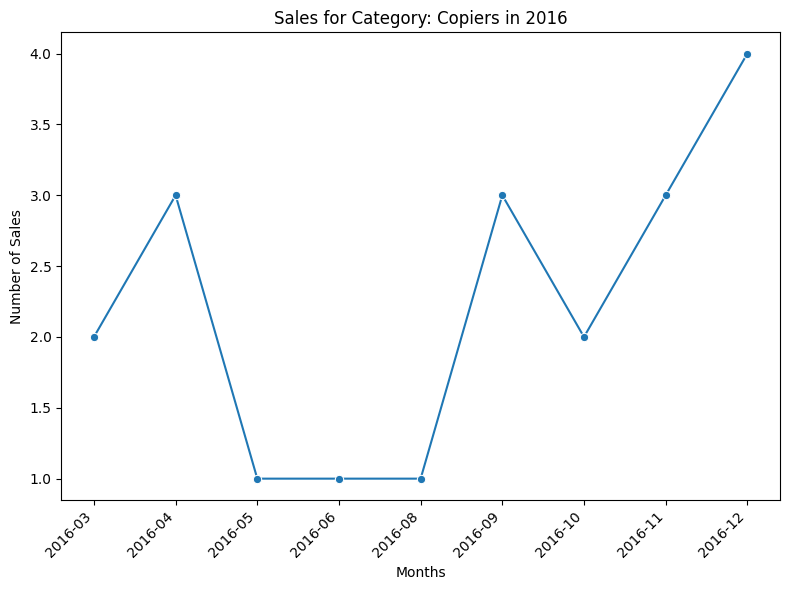

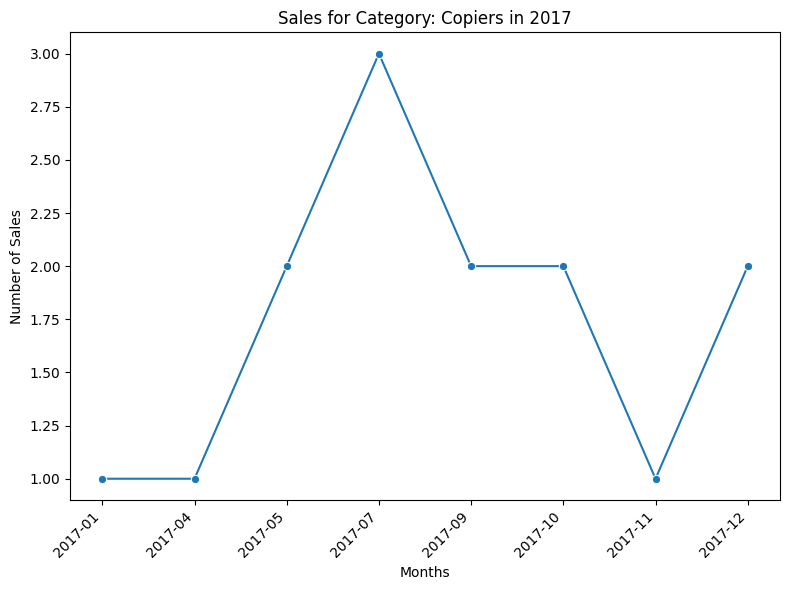

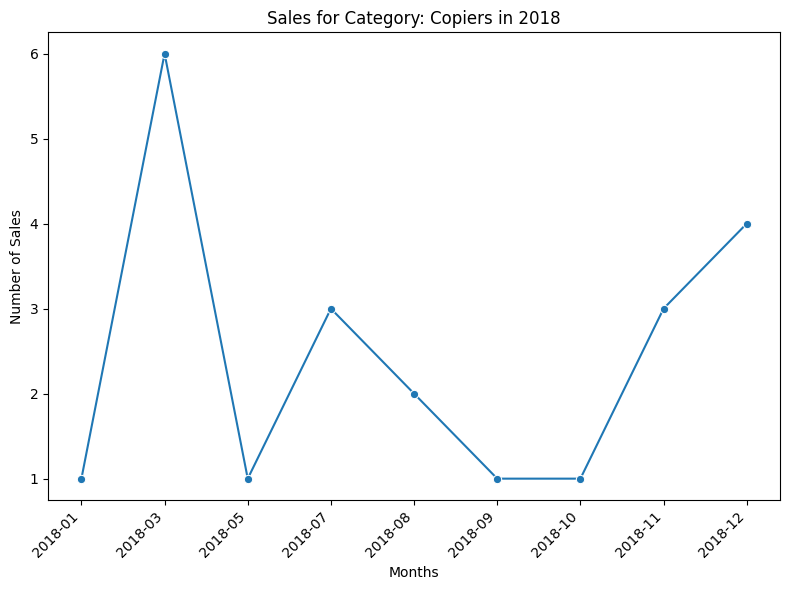

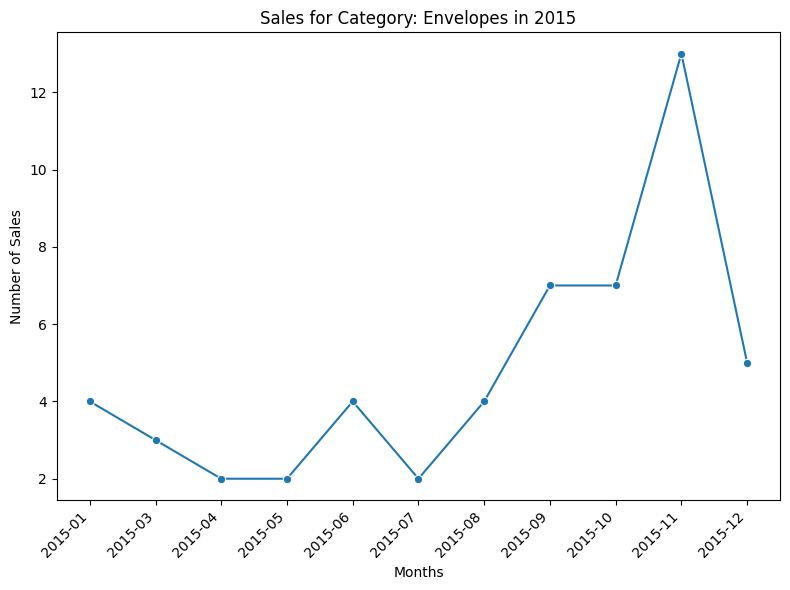

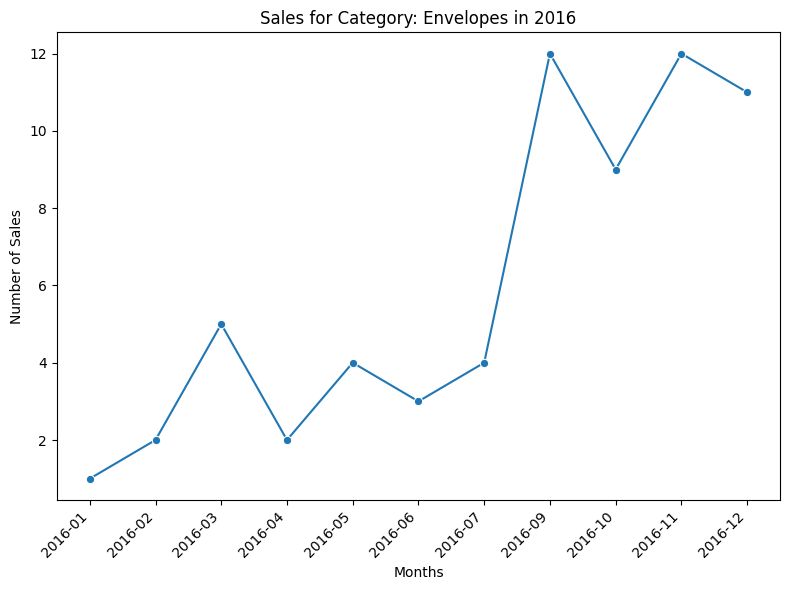

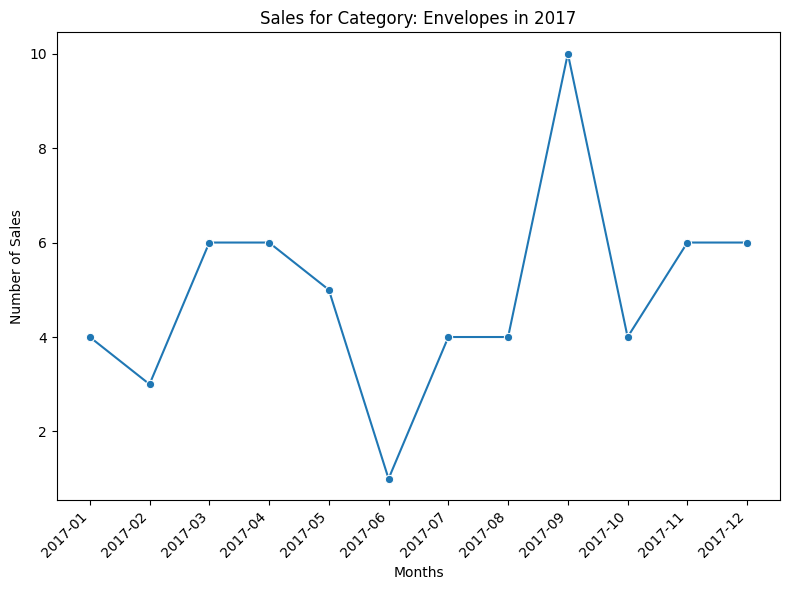

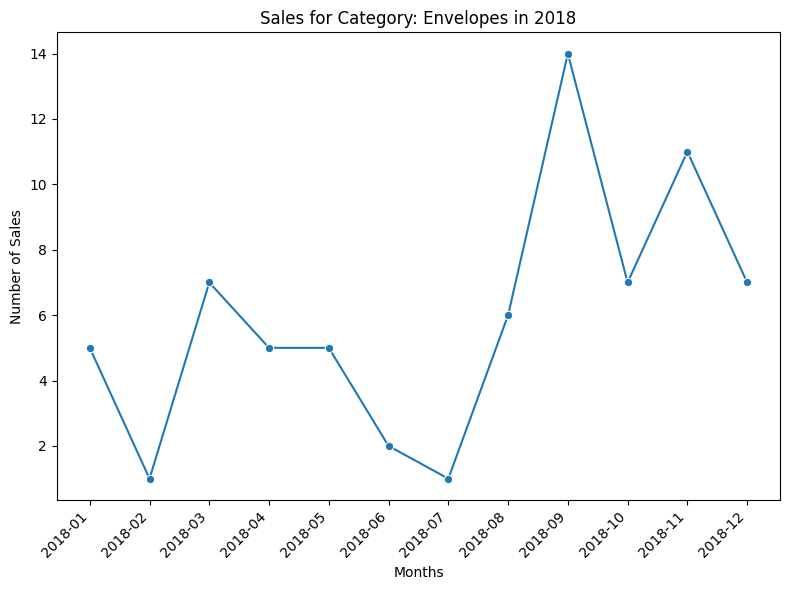

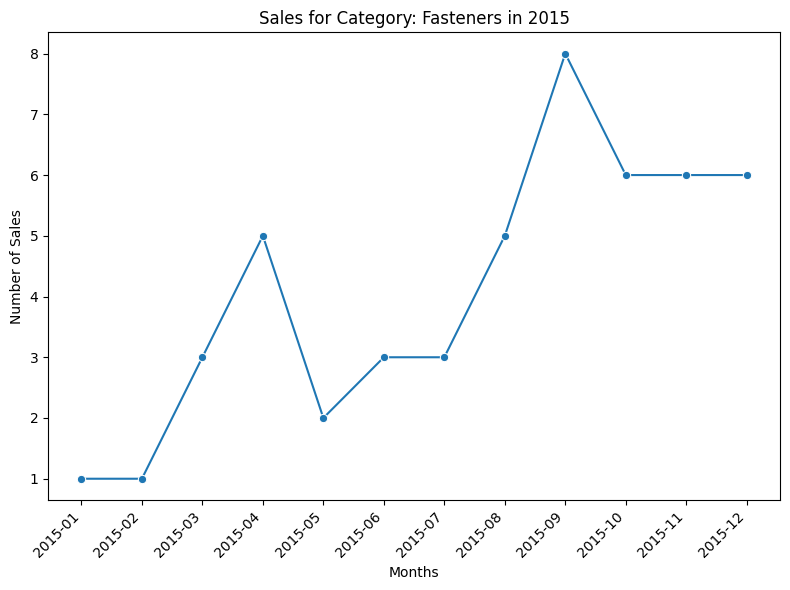

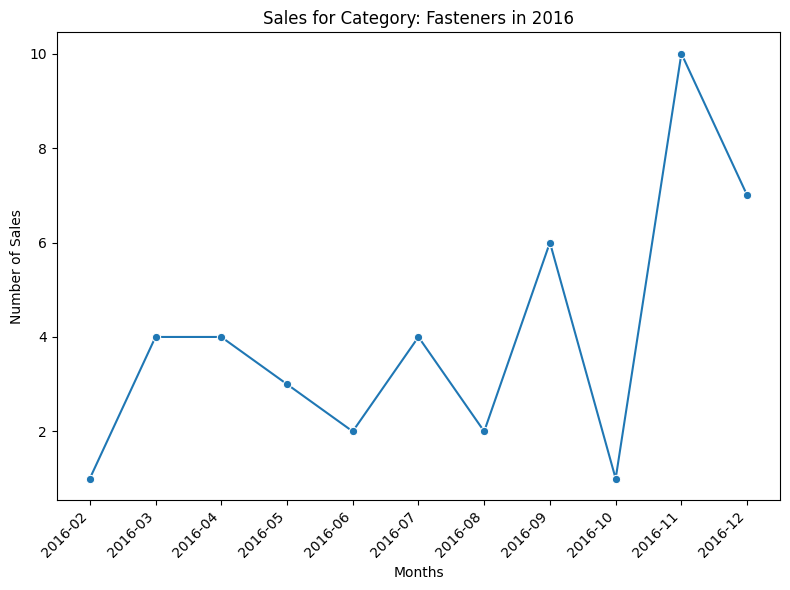

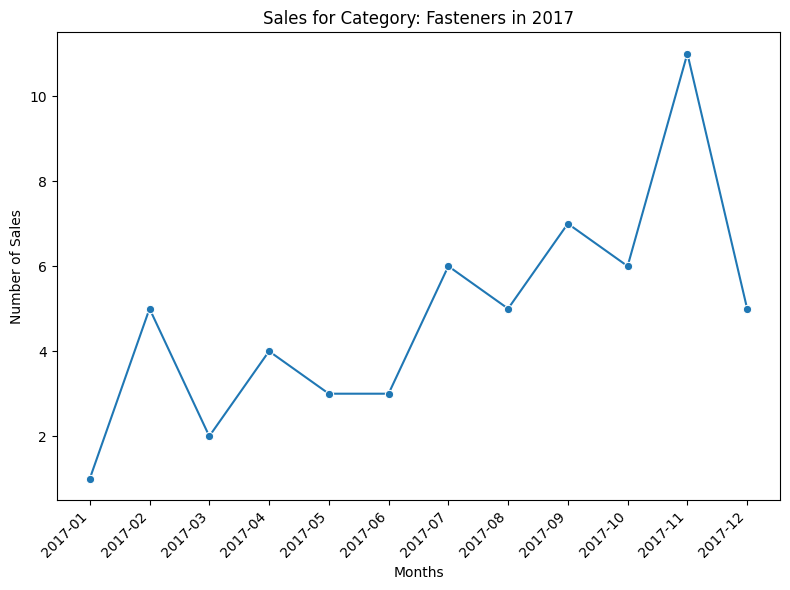

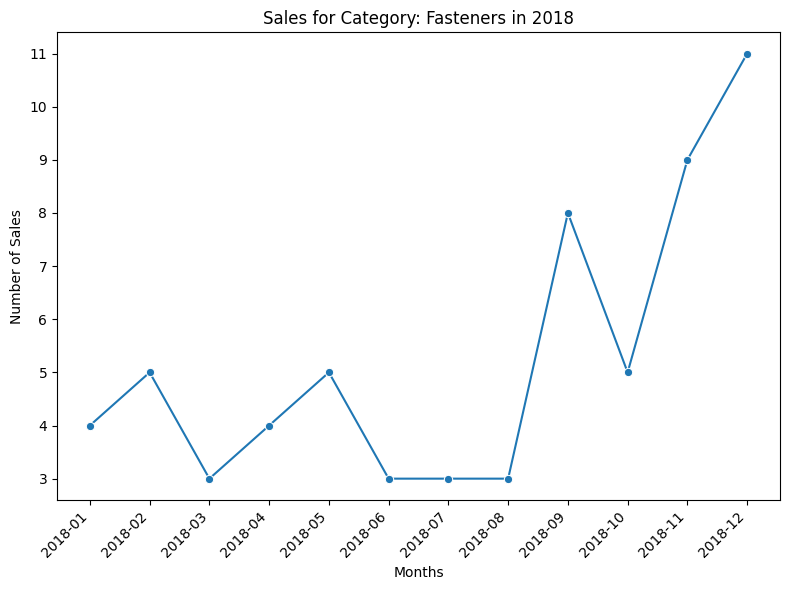

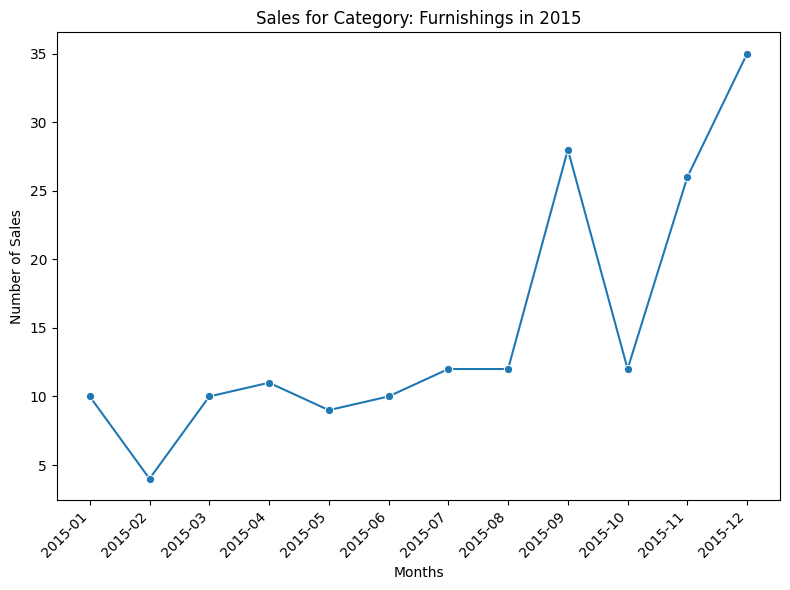

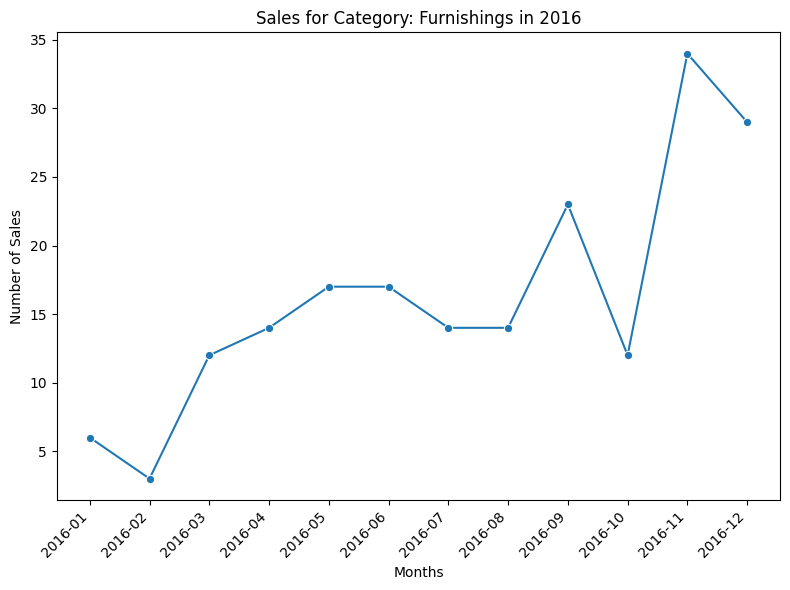

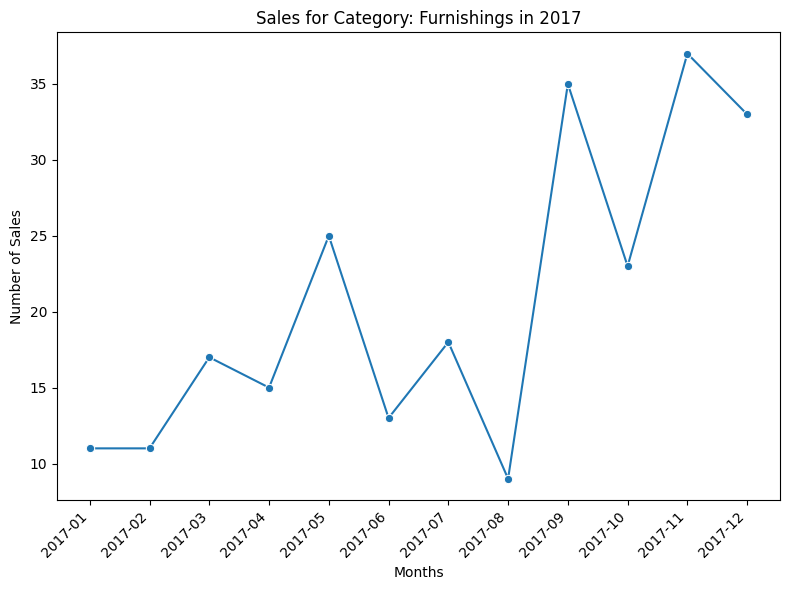

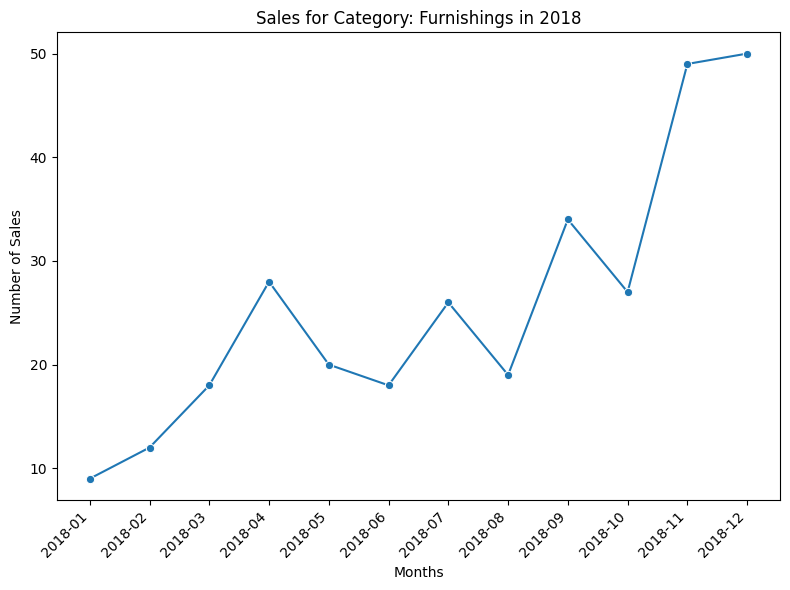

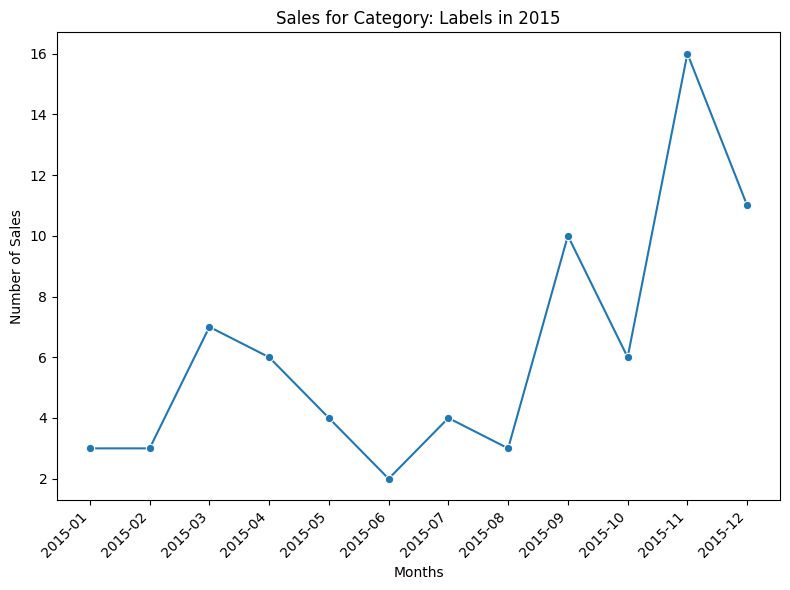

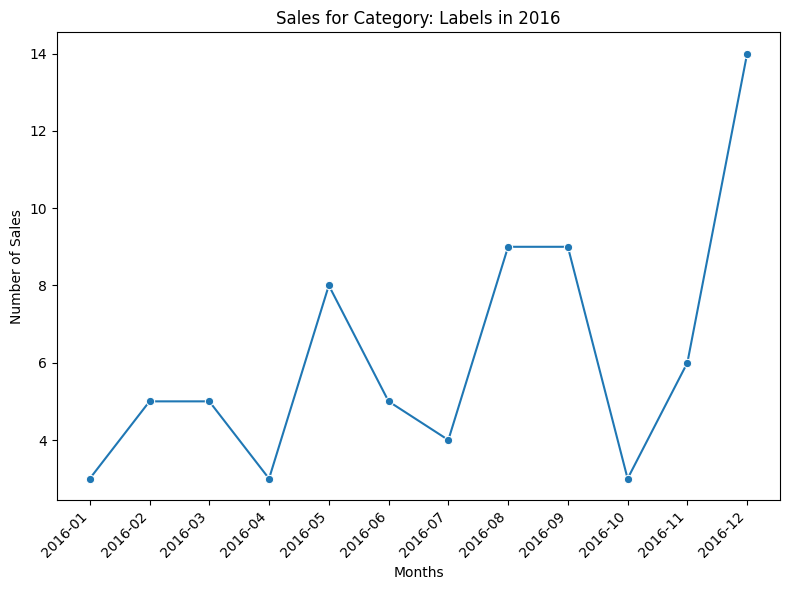

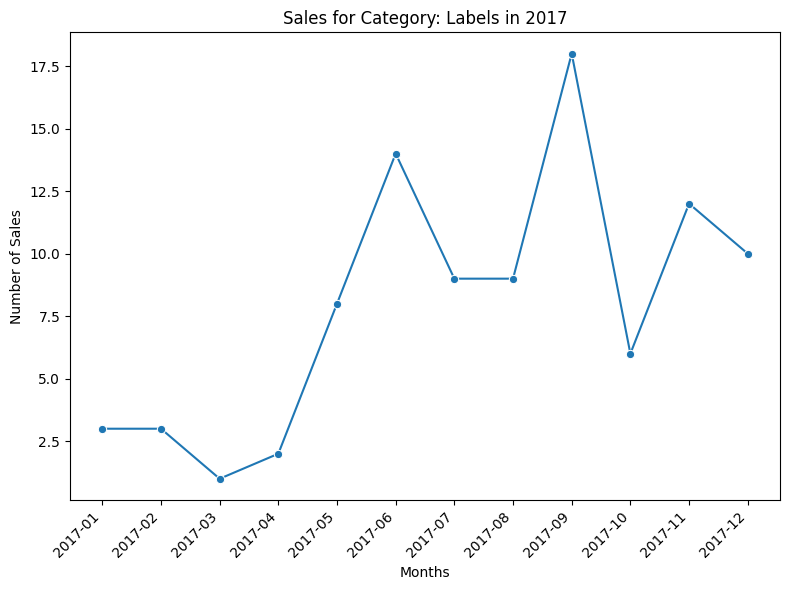

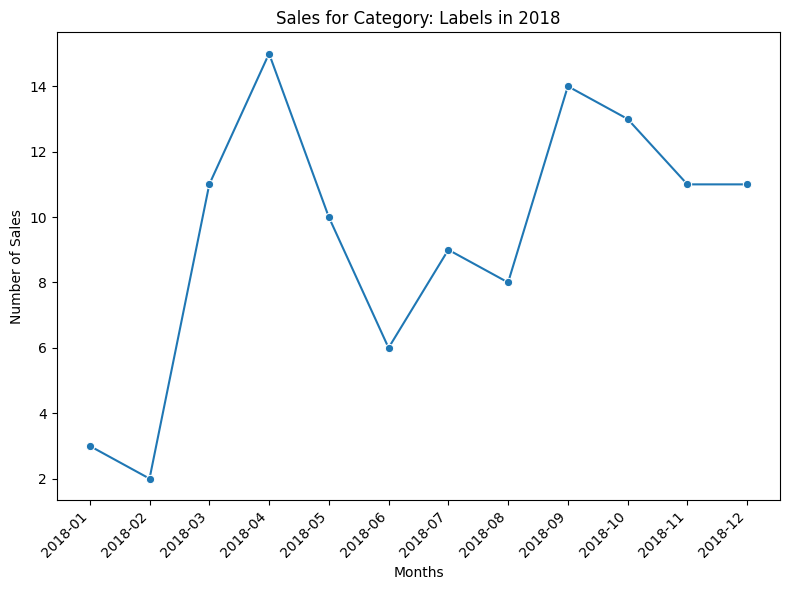

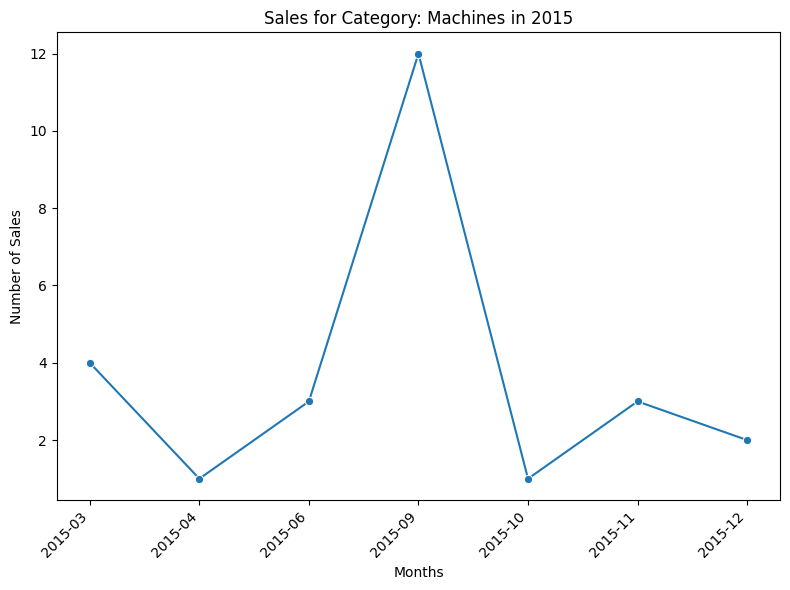

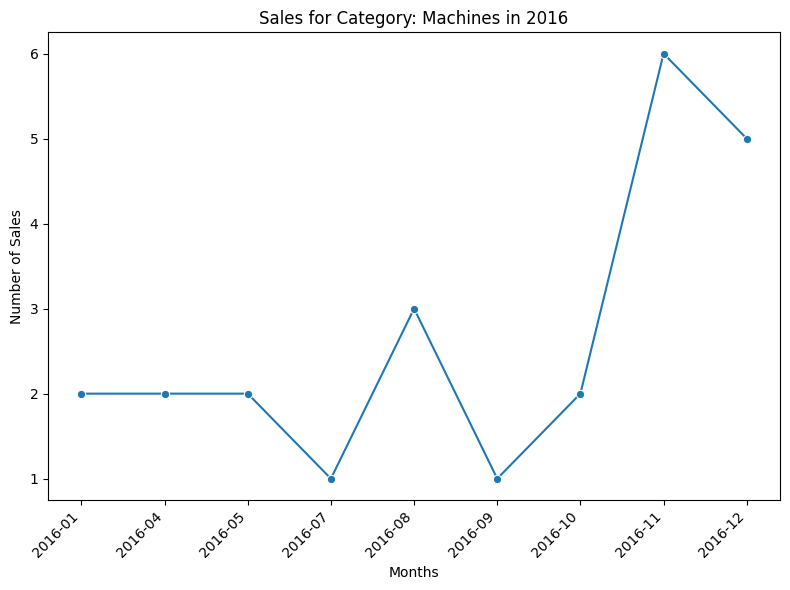

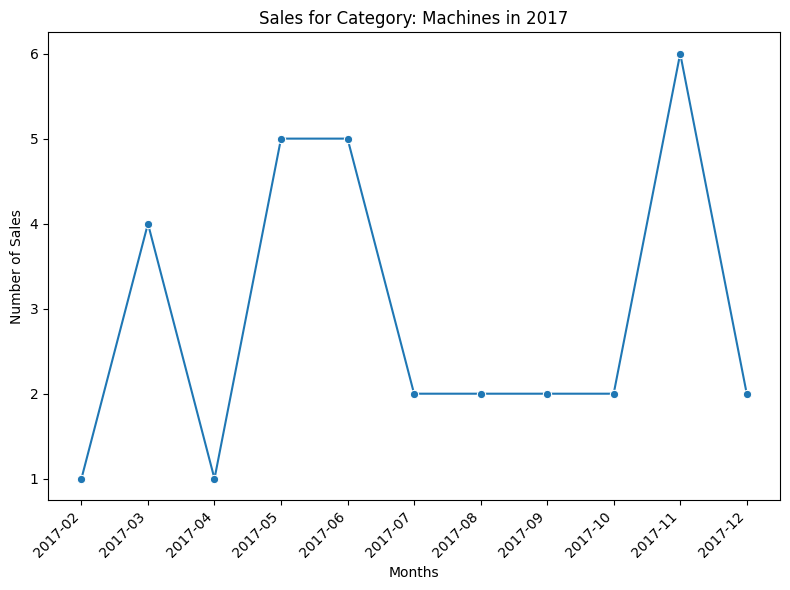

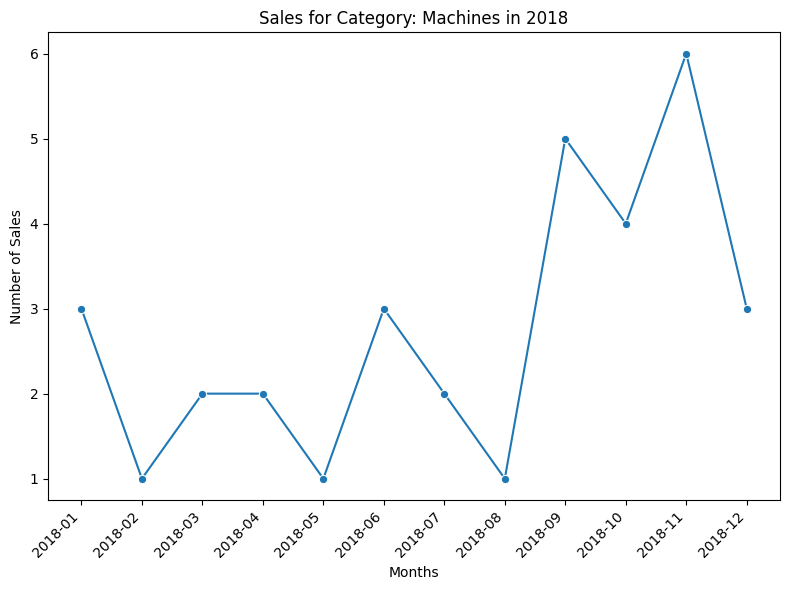

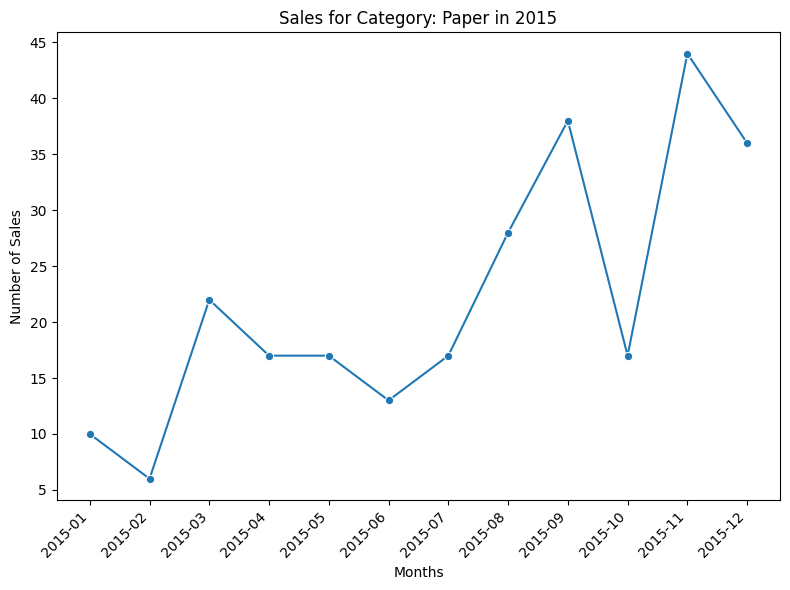

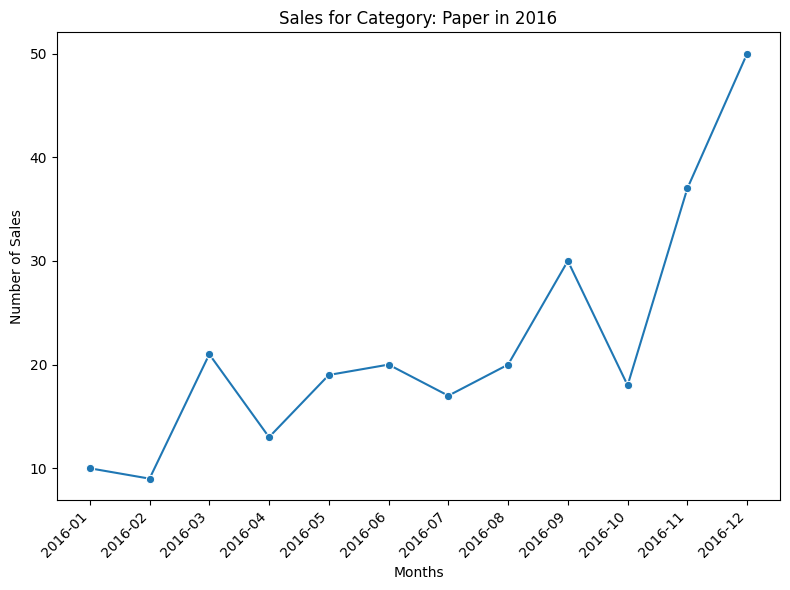

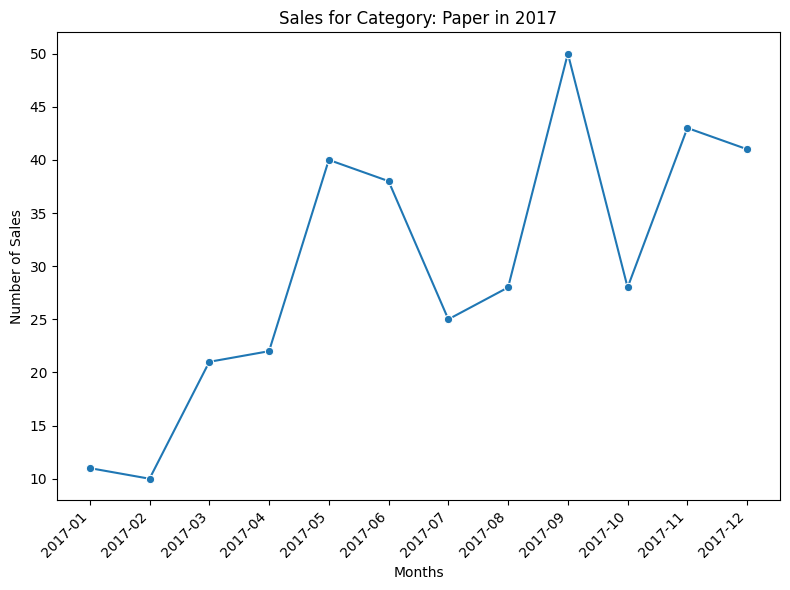

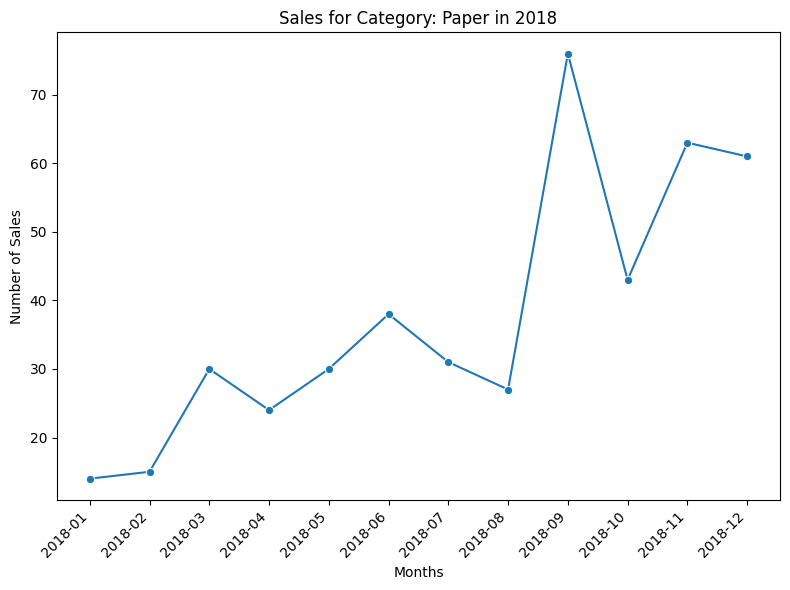

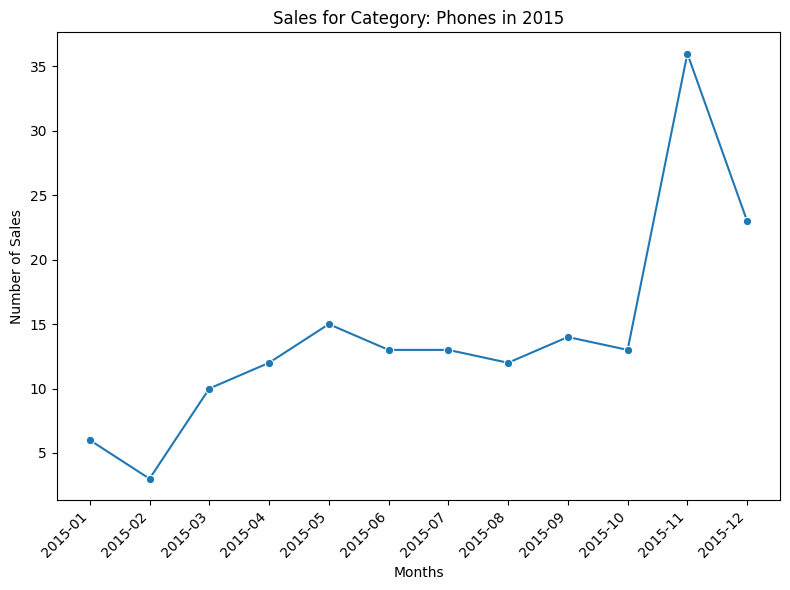

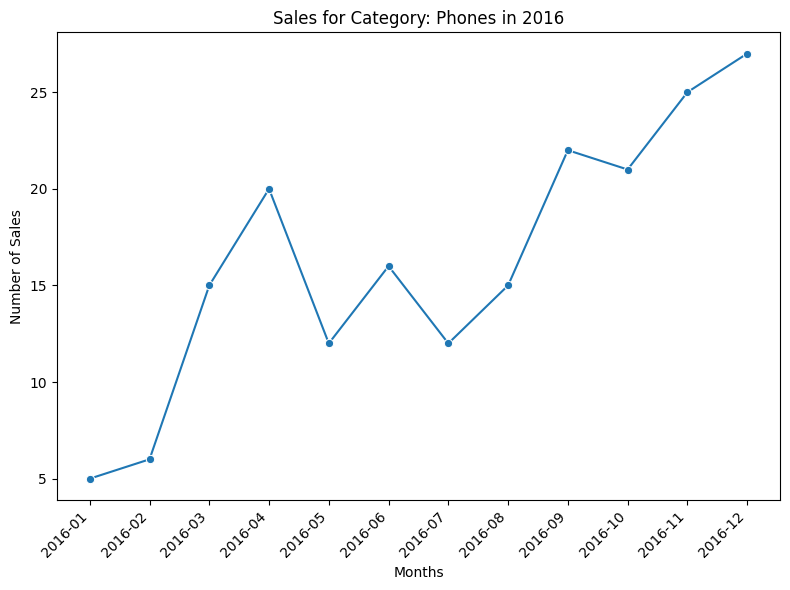

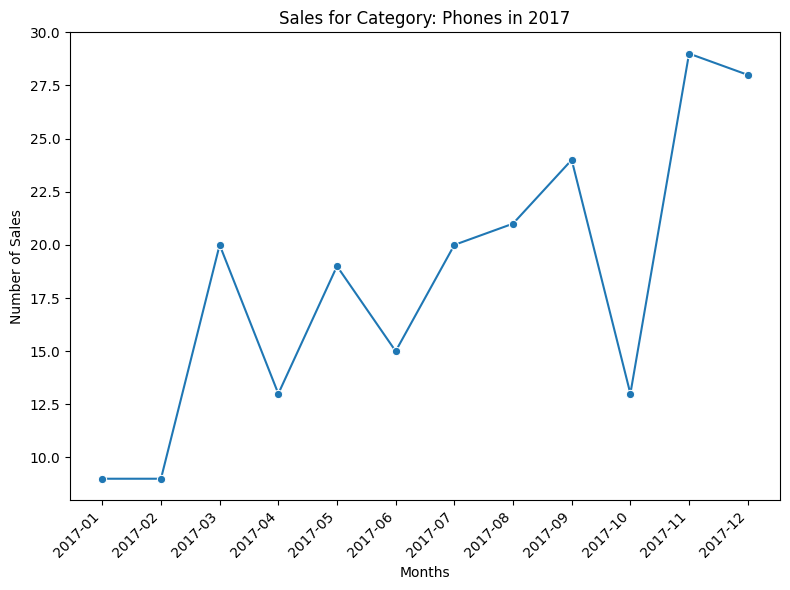

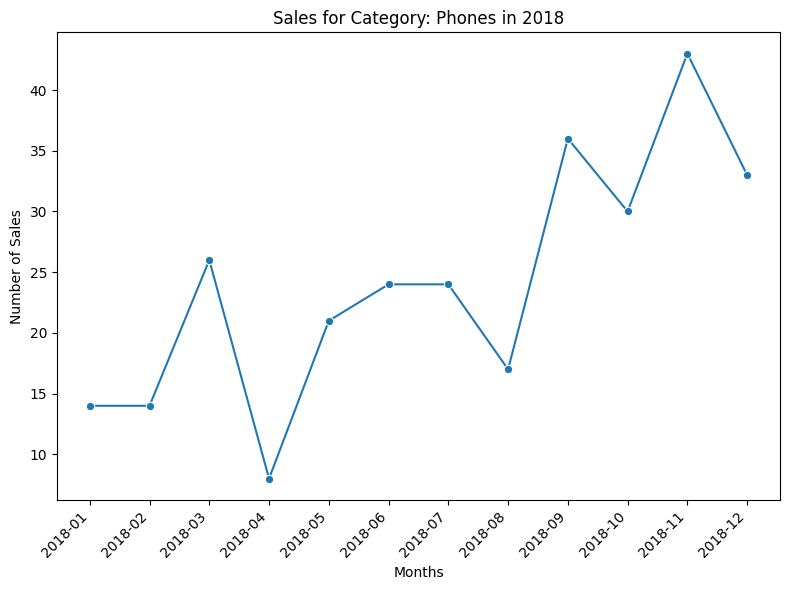

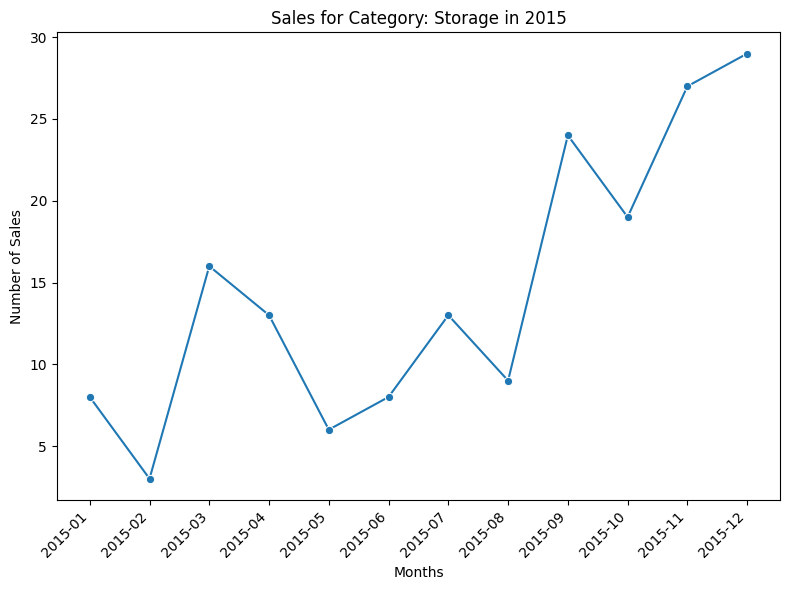

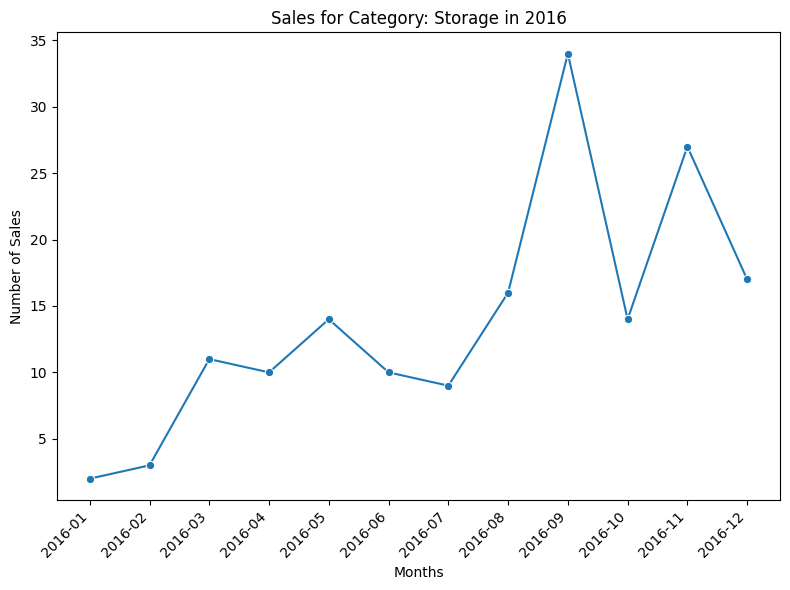

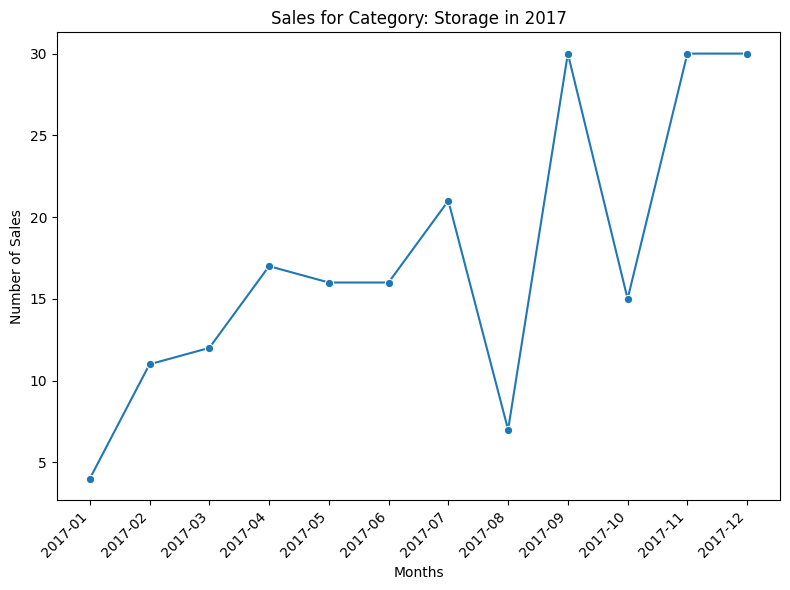

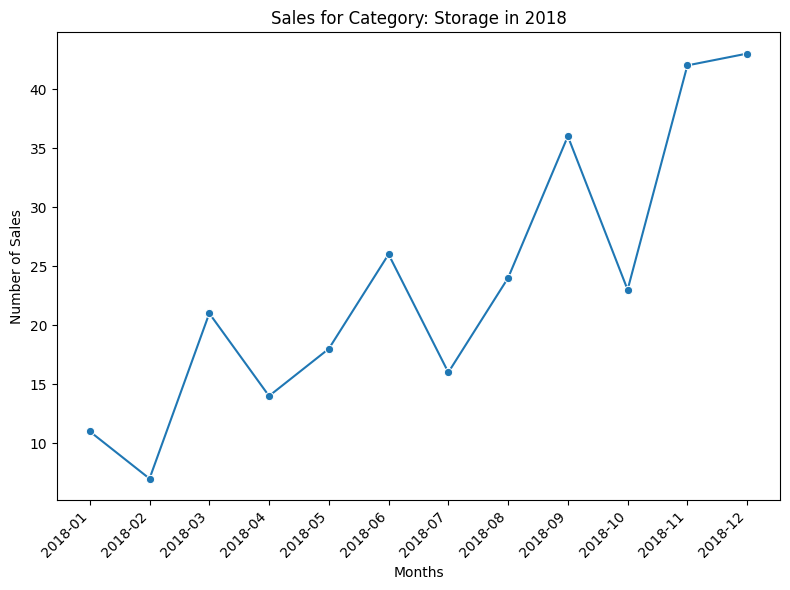

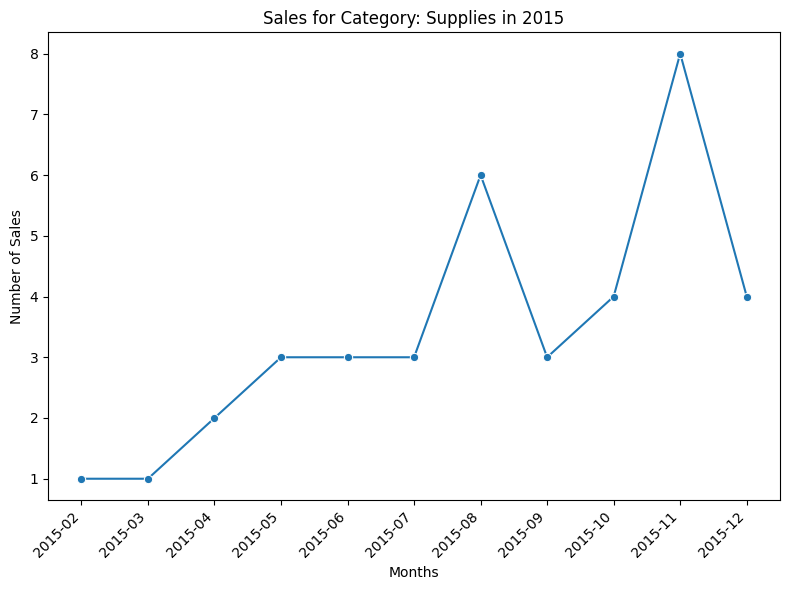

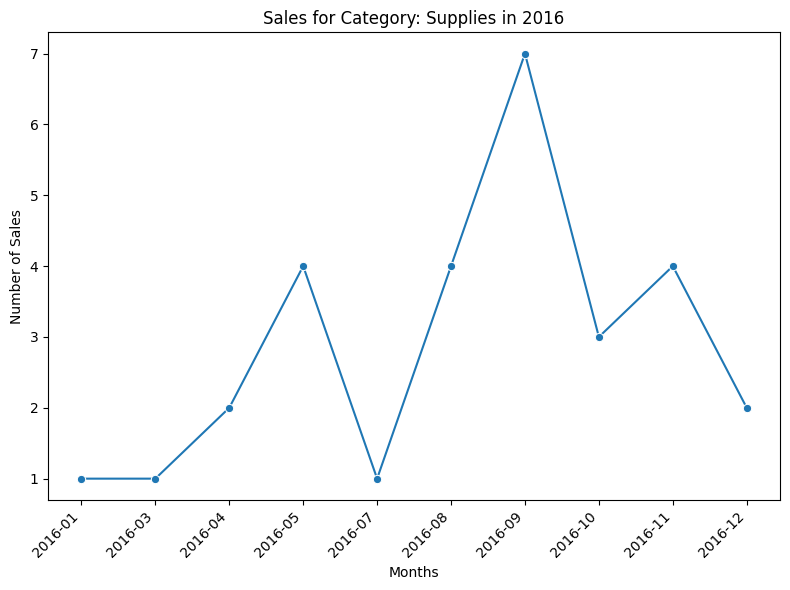

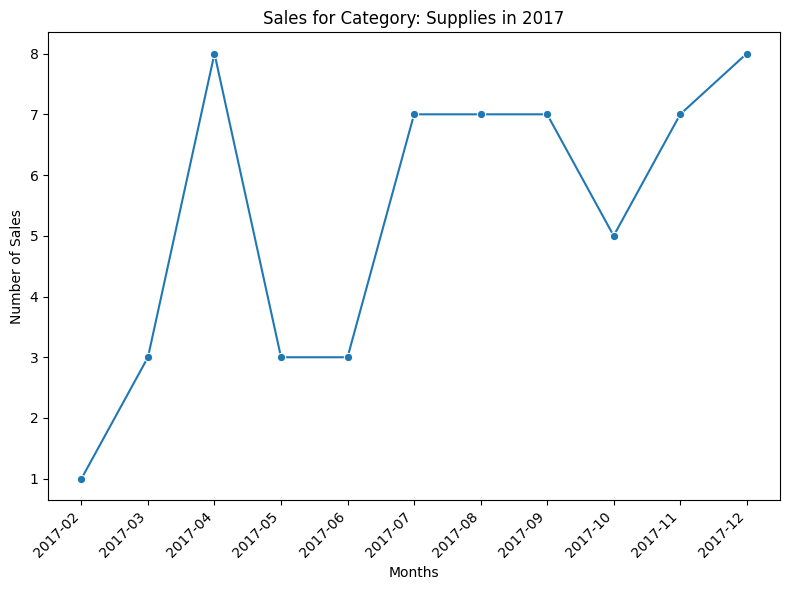

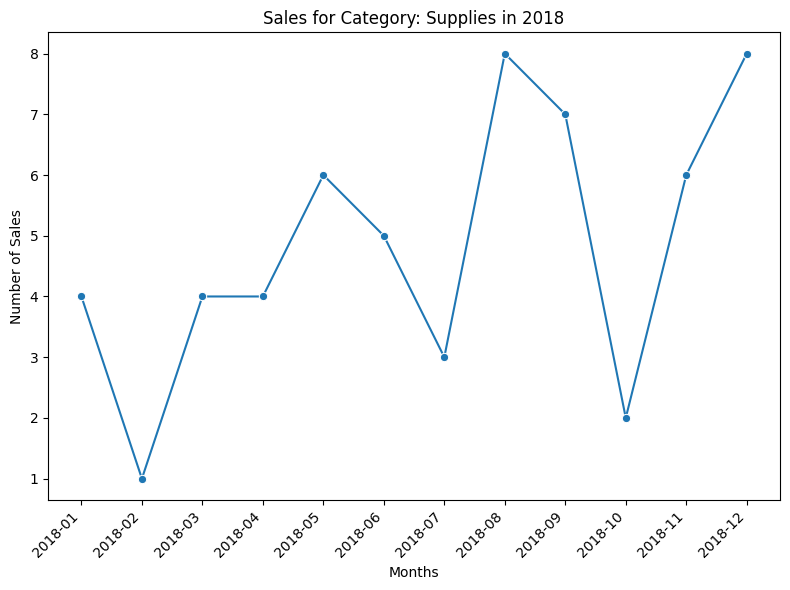

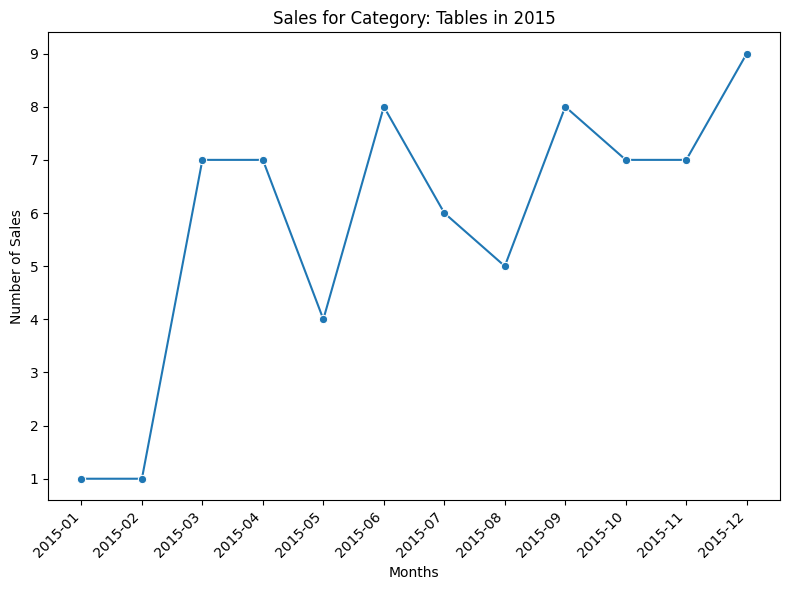

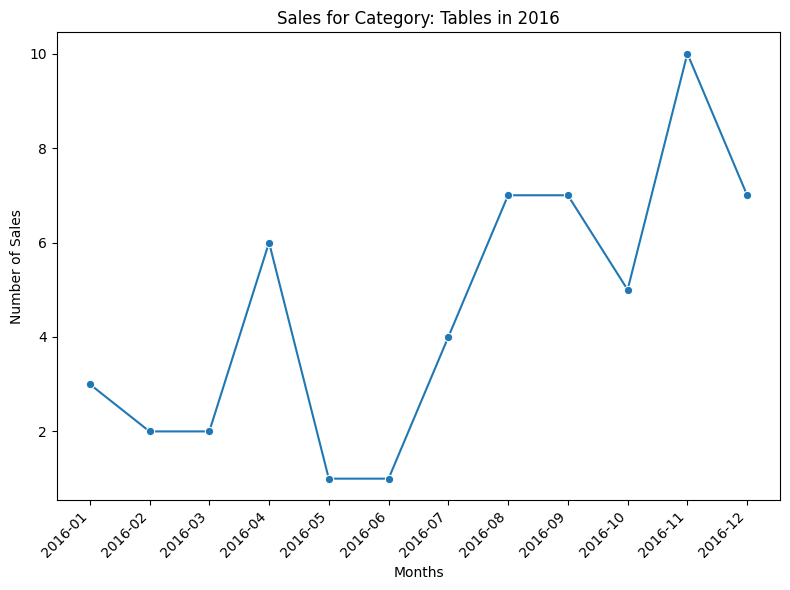

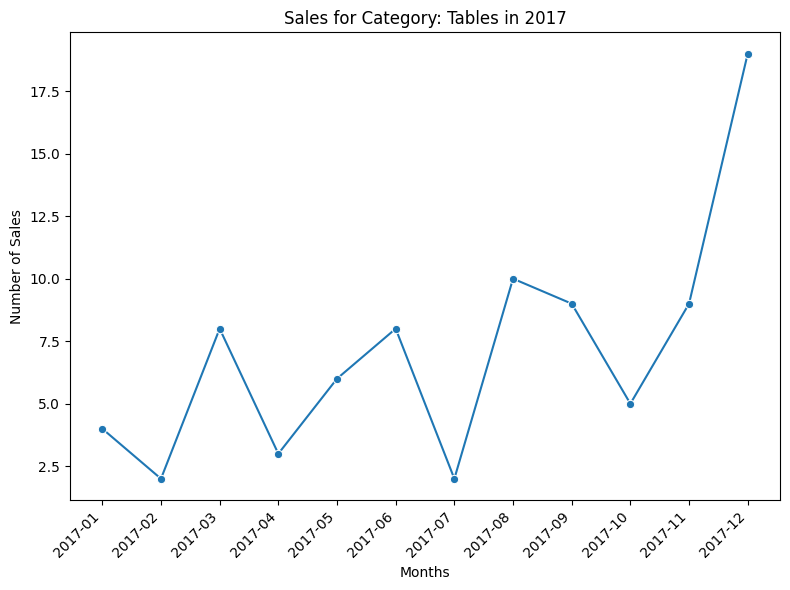

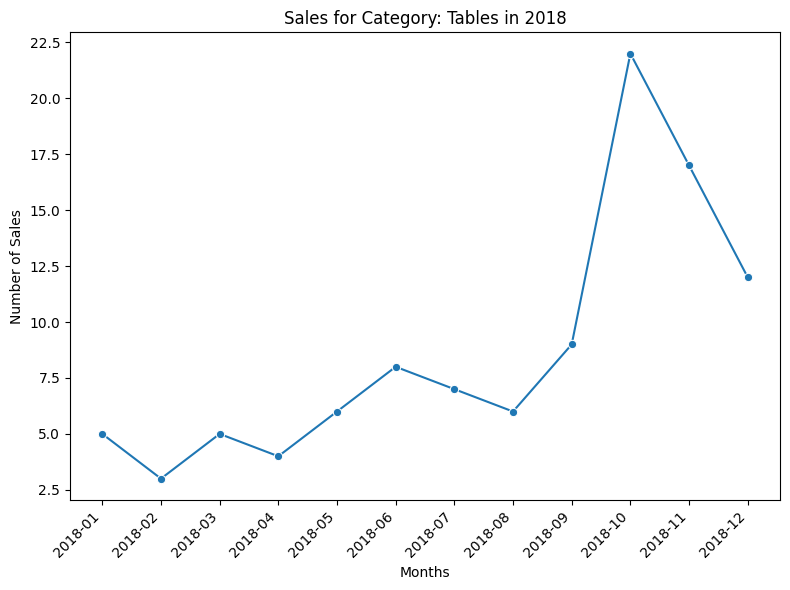

In [ ]:
# visualize the sales by year for each category
for category in categories:
  category_df = sales_by_months[sales_by_months['Sub-Category'] == category]
  for year in years:
    years_df = category_df[category_df['Year_Order'] == year]
    plt.figure(figsize=(8,6))
    sns.lineplot(data=years_df, x='Year_Month_Order', y='Number of Sales', marker='o')
    plt.title(f'Sales for Category: {category} in {year}')
    plt.xlabel('Months')
    plt.ylabel('Number of Sales')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Further data visualization and EDA

In [ ]:
df.sort_values(by=['Order Date'], inplace=True, ascending=True)
df.set_index('Order Date', inplace=True)
df.head()

Order ID  Ship Date       Ship Mode Customer ID  \
Order Date                                                          
2015-01-03  CA-2015-103800 2015-01-07  Standard Class    DP-13000   
2015-01-04  CA-2015-112326 2015-01-08  Standard Class    PO-19195   
2015-01-04  CA-2015-112326 2015-01-08  Standard Class    PO-19195   
2015-01-04  CA-2015-112326 2015-01-08  Standard Class    PO-19195   
2015-01-05  CA-2015-141817 2015-01-12  Standard Class    MB-18085   

            Customer Name      Segment        Country          City  \
Order Date                                                            
2015-01-03  Darren Powers     Consumer  United States       Houston   
2015-01-04  Phillina Ober  Home Office  United States    Naperville   
2015-01-04  Phillina Ober  Home Office  United States    Naperville   
2015-01-04  Phillina Ober  Home Office  United States    Naperville   
2015-01-05     Mick Brown     Consumer  United States  Philadelphia   

                   State  Postal Code   Region       Product ID  \
Order Date                                                        
2015-01-03         Texas      77095.0  Central  OFF-PA-10000174   
2015-01-04      Illinois      60540.0  Central  OFF-BI-10004094   
2015-01-04      Illinois      60540.0  Central  OFF-ST-10002743   
2015-01-04      Illinois      60540.0  Central  OFF-LA-10003223   
2015-01-05  Pennsylvania      19143.0     East  OFF-AR-10003478   

                   Category Sub-Category  \
Order Date                                 
2015-01-03  Office Supplies        Paper   
2015-01-04  Office Supplies      Binders   
2015-01-04  Office Supplies      Storage   
2015-01-04  Office Supplies       Labels   
2015-01-05  Office Supplies          Art   

                                                 Product Name    Sales  
Order Date                                                              
2015-01-03  Message Book, Wirebound, Four 5 1/2" X 4" Form...   16.448  
2015-01-04         GBC Standard Plastic Binding Systems Combs    3.540  
2015-01-04                      SAFCO Boltless Steel Shelving  272.736  
2015-01-04                                          Avery 508   11.784  
2015-01-05  Avery Hi-Liter EverBold Pen Style Fluorescent ...   19.536

In [ ]:
df['Postal Code'] = df['Postal Code'].fillna(5401)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 2015-01-03 to 2018-12-30
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       9800 non-null   object        
 1   Ship Date      9800 non-null   datetime64[ns]
 2   Ship Mode      9800 non-null   object        
 3   Customer ID    9800 non-null   object        
 4   Customer Name  9800 non-null   object        
 5   Segment        9800 non-null   object        
 6   Country        9800 non-null   object        
 7   City           9800 non-null   object        
 8   State          9800 non-null   object        
 9   Postal Code    9800 non-null   float64       
 10  Region         9800 non-null   object        
 11  Product ID     9800 non-null   object        
 12  Category       9800 non-null   object        
 13  Sub-Category   9800 non-null   object        
 14  Product Name   9800 non-null   object        
 15  Sal

In [ ]:
top_customers = df.groupby(['Customer Name'])['Sales'].sum().sort_values(ascending=False).head(10)
top_customers = top_customers.round(2)
top_customers = top_customers.reset_index()

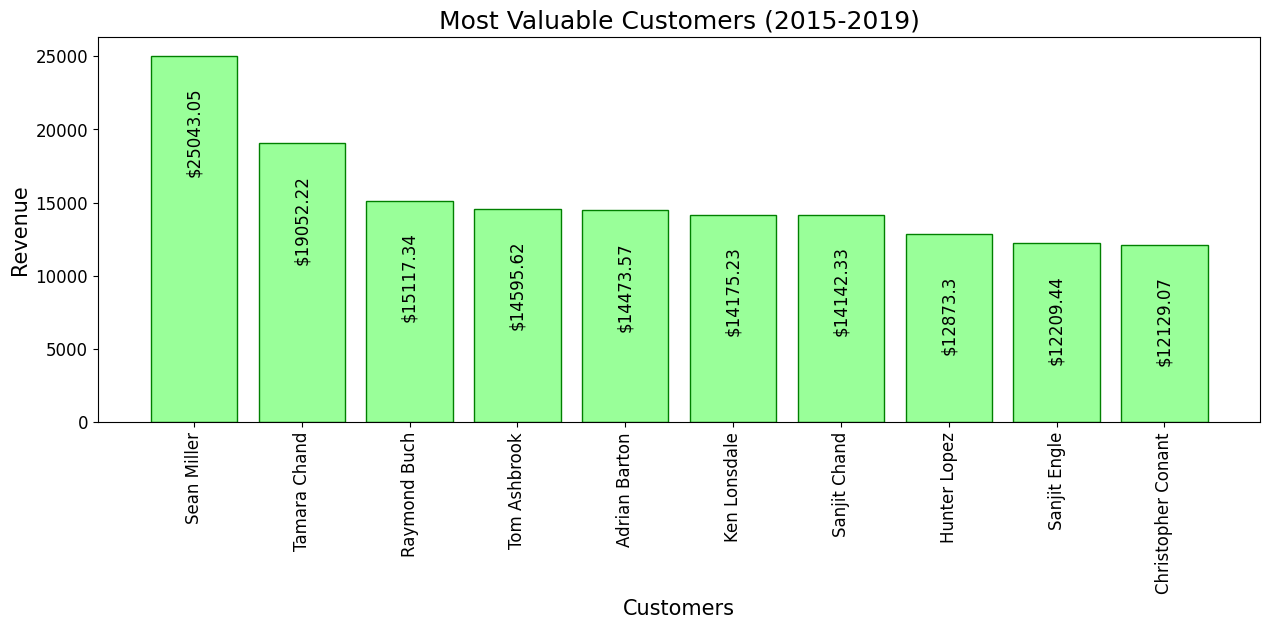

In [ ]:
plt.figure(figsize = (15,5))
plt.title("Most Valuable Customers (2015-2019)", fontsize=18)
plt.bar(top_customers['Customer Name'], top_customers['Sales'], color= '#99ff99',edgecolor='green', linewidth = 1)
plt.xlabel("Customers",fontsize=15)
plt.ylabel("Revenue",fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
for k,v in top_customers["Sales"].items(): #To show the exact revenue generated on the figure
    plt.text(k,v-8000,'$'+ str(v), fontsize=12,rotation=90,color='k', horizontalalignment='center');

In [ ]:
top_states = df.groupby(['State'])['Sales'].sum().sort_values(ascending=False).head(10)
top_states = top_states.round(2)
top_states = top_states.reset_index()

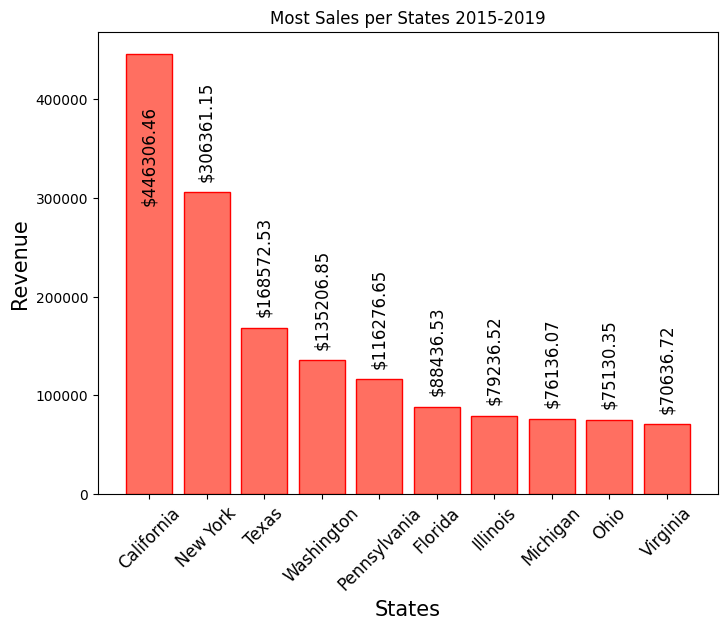

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Most Sales per States 2015-2019')
plt.bar(top_states['State'], top_states['Sales'], color= '#FF6F61',edgecolor='Red', linewidth = 1)
plt.xlabel('States', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.xticks(fontsize=12, rotation=45)
for k,v in top_states['Sales'].items():
  if v > 400000:
    plt.text(k,v-150000, '$' + str(v), fontsize=12, color='k', rotation=90, horizontalalignment='center')
  else:
    plt.text(k,v+15000, '$' + str(v), fontsize=12, color='k', rotation=90, horizontalalignment='center')

In [ ]:
top_cities = df.groupby(['City'])['Sales'].sum().sort_values(ascending=False).head(10)
top_cities = top_cities.round(2)
top_cities = top_cities.reset_index()

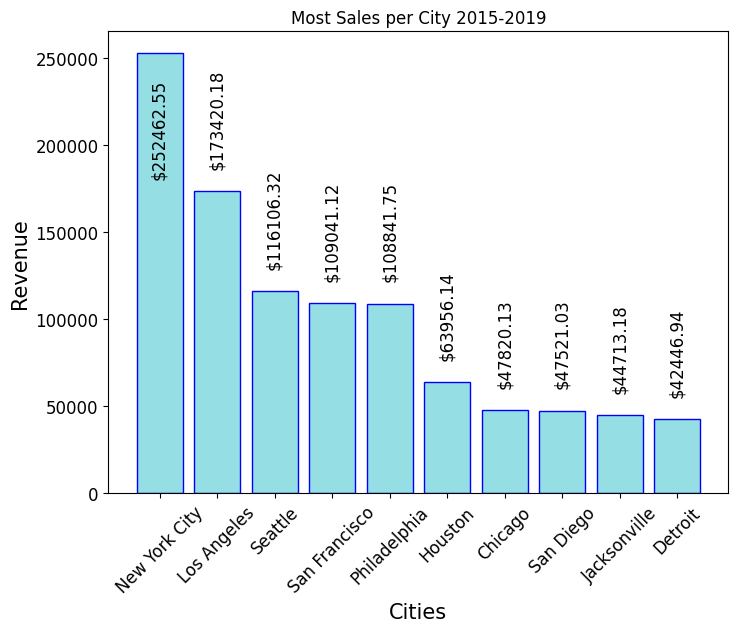

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Most Sales per City 2015-2019')
plt.bar(top_cities['City'], top_cities['Sales'], color= '#95DEE3',edgecolor='blue', linewidth = 1)
plt.xlabel('Cities', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
for k,v in top_cities['Sales'].items():
  if v > 250000:
    plt.text(k,v-70000, '$' + str(v), fontsize=12, color='k', rotation=90, horizontalalignment='center')
  else:
    plt.text(k,v+15000, '$' + str(v), fontsize=12, color='k', rotation=90, horizontalalignment='center')

In [ ]:
top_categories = df.groupby(['Category'])['Sales'].sum().sort_values(ascending=False).head(10)
top_categories = top_categories.round(2)
top_categories = top_categories.reset_index()

In [ ]:
top_categories.head()

Category      Sales
0       Technology  827455.87
1        Furniture  728658.58
2  Office Supplies  705422.33

In [ ]:
top_products = df.groupby(['Product Name'])['Sales'].sum().sort_values(ascending=False)
top_products = top_products.round(2)
top_products = top_products.reset_index()
top_products.head()

Product Name     Sales
0              Canon imageCLASS 2200 Advanced Copier  61599.82
1  Fellowes PB500 Electric Punch Plastic Comb Bin...  27453.38
2  Cisco TelePresence System EX90 Videoconferenci...  22638.48
3       HON 5400 Series Task Chairs for Big and Tall  21870.58
4         GBC DocuBind TL300 Electric Binding System  19823.48

In [ ]:
top_cat = df.groupby(['Category', 'Sub-Category'])['Sales'].sum().sort_values(ascending=False)
top_cat = top_cat.round(2)
top_cat = top_cat.reset_index()
top_cat.head()

Category Sub-Category      Sales
0       Technology       Phones  327782.45
1        Furniture       Chairs  322822.73
2  Office Supplies      Storage  219343.39
3        Furniture       Tables  202810.63
4  Office Supplies      Binders  200028.78

<Axes: >

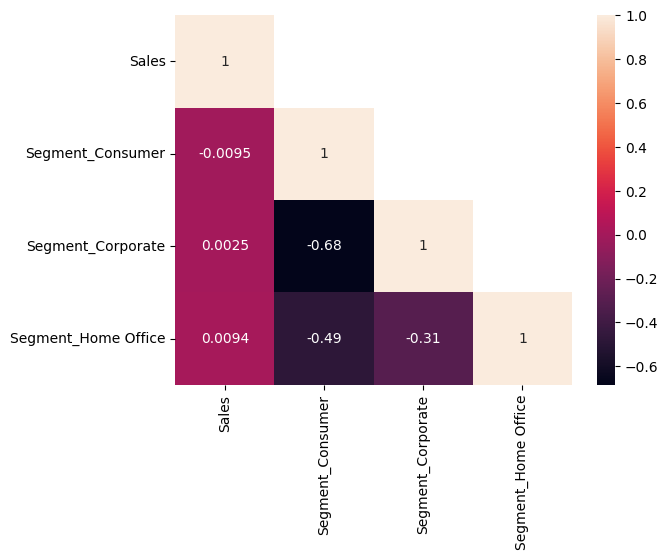

In [ ]:
df1 = df[['Segment', 'Sales']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
sns.heatmap(df_cat.corr(), annot=True, cbar=True, mask=mask)

<Axes: >

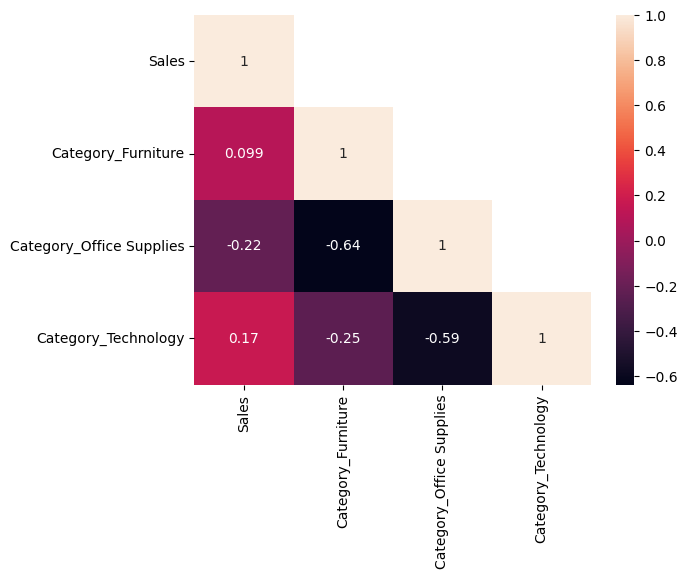

In [ ]:
df2= df[['Category','Sales']]
df_cat = pd.get_dummies(df2)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
sns.heatmap(df_cat.corr(), annot=True, cbar=True, mask=mask)

<Axes: >

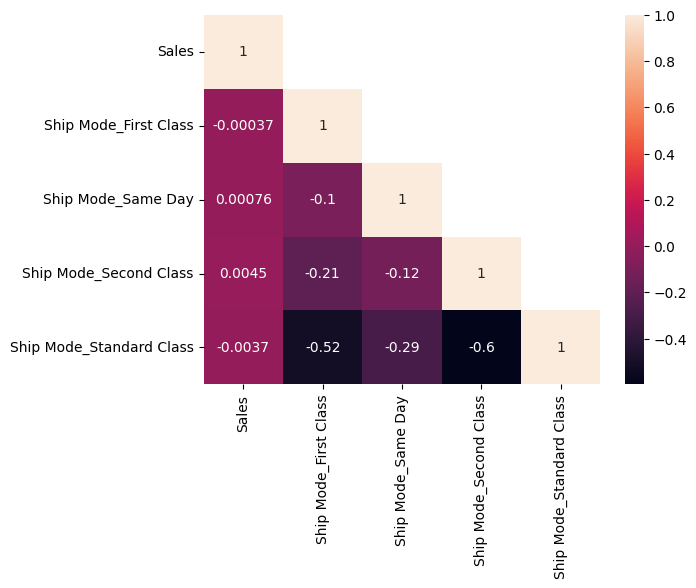

In [ ]:
df3 = df[['Ship Mode','Sales']]
df_cat = pd.get_dummies(df3)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
sns.heatmap(df_cat.corr(), annot=True, cbar=True, mask=mask)

# Building the model to predict sales over time

In [ ]:
new_data = pd.DataFrame(df['Sales'])
new_data.head()

Sales
Order Date         
2015-01-03   16.448
2015-01-04    3.540
2015-01-04  272.736
2015-01-04   11.784
2015-01-05   19.536

Based on the diagram, the data does look stationary, meaning that there are no significant seasonal trends. But we can make sure by computations.

<Axes: xlabel='Order Date'>

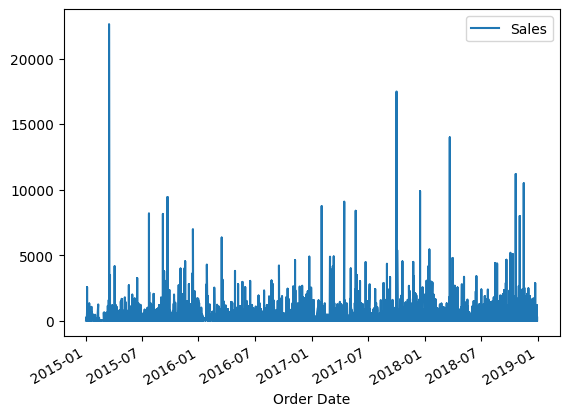

In [ ]:
new_data.plot()

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Using daily resampling since the original dataset is set in days
new_data =  pd.DataFrame(new_data['Sales'].resample('D').mean())
# Handles missing values that I might have missed
new_data = new_data.interpolate(method='linear')

adf = adfuller(new_data)

print(adf)
print('\nADF = ', str(adf[0])) #more towards negative value the better
print('\np-value = ', str(adf[1]))
print('\nCritical Values: ')

for key, val in adf[4].items(): #for loop to print the p-value (1%, 5% and 10%) and their respective values
    print(key,':',val)


    if adf[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')

(np.float64(-20.809458514839335), 0.0, 2, 1455, {'1%': np.float64(-3.4348523191002123), '5%': np.float64(-2.8635284734563364), '10%': np.float64(-2.567828646449617)}, np.float64(20042.15494613892))

ADF =  -20.809458514839335

p-value =  0.0

Critical Values: 
1% : -3.4348523191002123
Null Hypothesis Rejected. Time Series is Stationary
5% : -2.8635284734563364
Null Hypothesis Rejected. Time Series is Stationary
10% : -2.567828646449617
Null Hypothesis Rejected. Time Series is Stationary


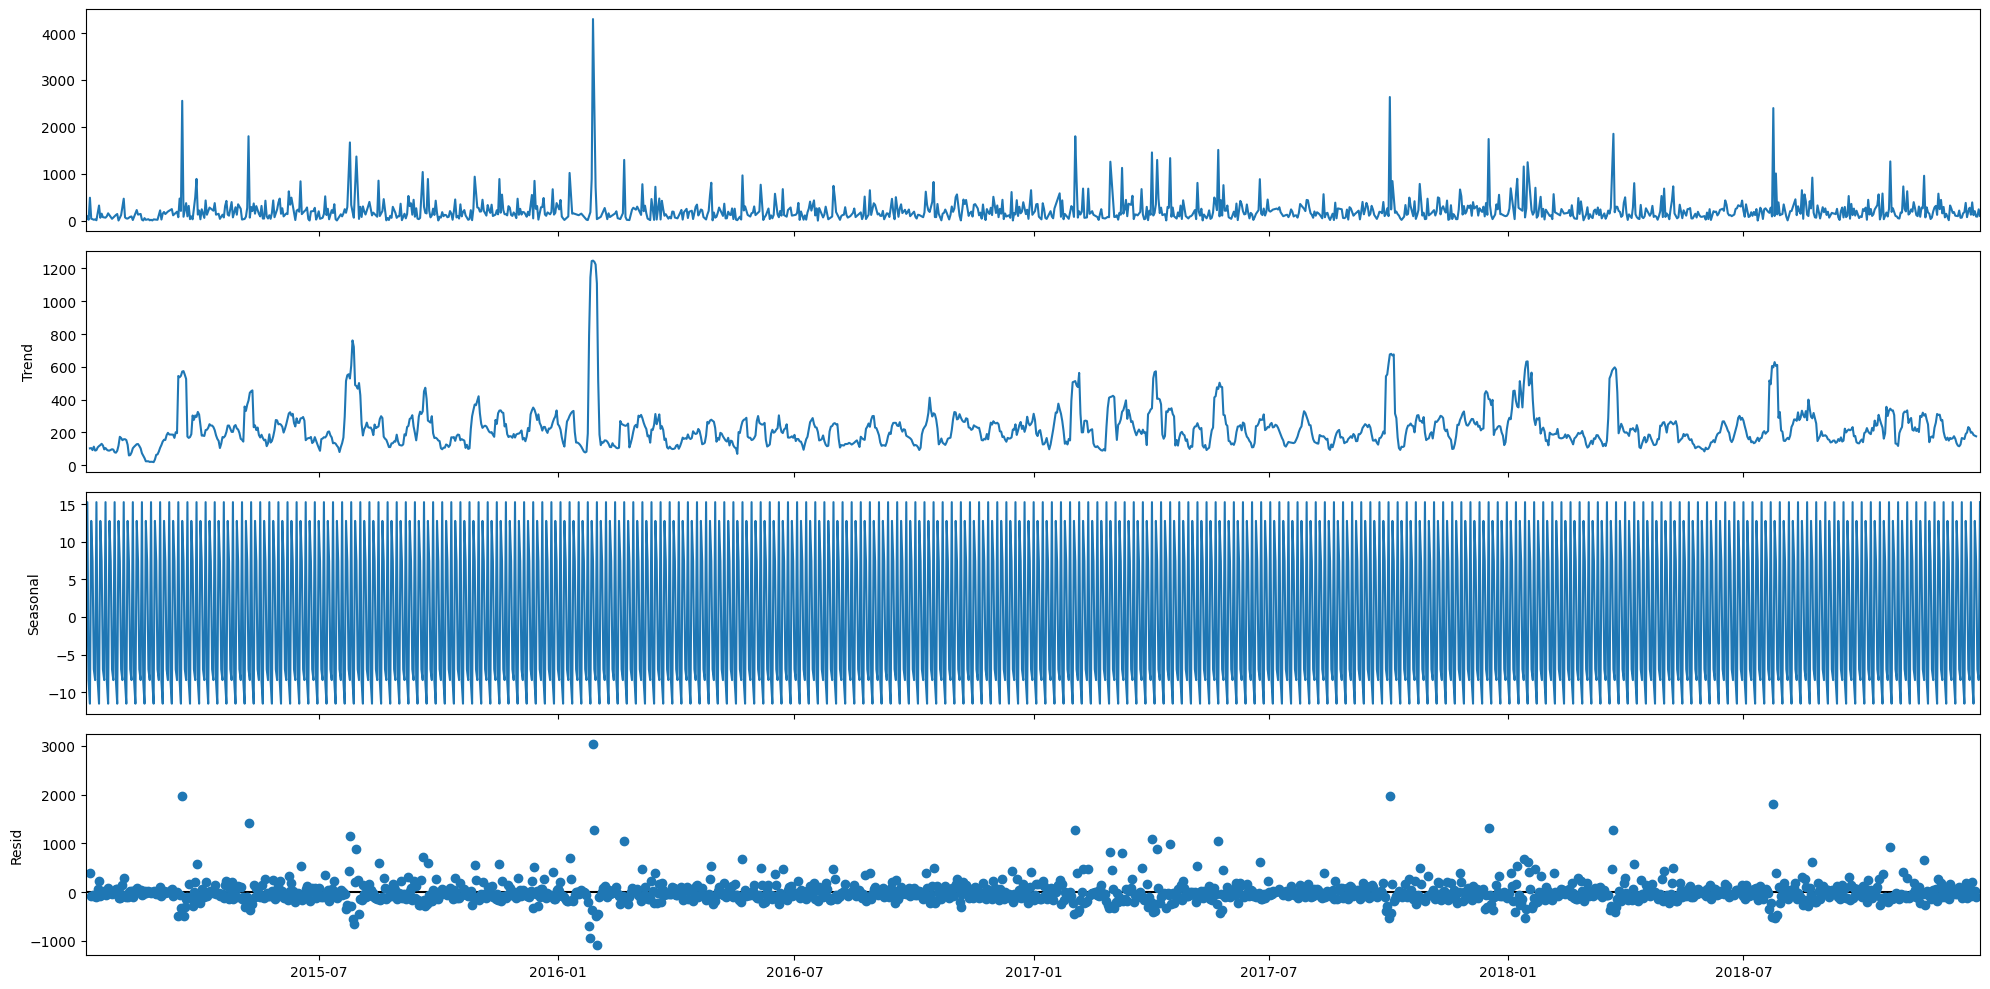

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(new_data, model='additive') #function used to decompose Time Series Data into Trend and Seasonality
fig = decomposition.plot()
plt.show()

In [ ]:
import itertools
# SARIMA(p,d,q) = indicating non-seasonality while referring to
# autoregressive (AR), integrated (I), and moving average (MA) orders
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq_comb = [(i[0], i[1], i[2], 12) for i in list(itertools.product(p, d, q))] #for loop for creating combinations of seasonal parameters of SARIMA
print('Examples of parameter combinations for Seasonal ARIMA:')
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[1]))
print('SARIMA: {} x {}'.format(pdq[1], seasonal_pdq_comb[2]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[3]))
print('SARIMA: {} x {}'.format(pdq[2], seasonal_pdq_comb[4]))

Examples of parameter combinations for Seasonal ARIMA:
SARIMA: (0, 0, 1) x (0, 0, 1, 12)
SARIMA: (0, 0, 1) x (0, 1, 0, 12)
SARIMA: (0, 1, 0) x (0, 1, 1, 12)
SARIMA: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for parameters in pdq: #for loop for determining the best combination of seasonal parameters for SARIMA
    for seasonal_param in seasonal_pdq_comb:
        try:
            mod = sm.tsa.statespace.SARIMAX(new_data,
                                            order=parameters,
                                            seasonal_param_order=seasonal_param,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False) #determines the AIC value of the model**
            results = mod.fit()
            print('SARIMA{}x{}12 - AIC:{}'.format(parameters, seasonal_param, results.aic))
        except:
            continue

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:21194.720419683938
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:21194.720419683938
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:21194.720419683938
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:21194.720419683938
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:21194.720419683938


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict

SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:21194.720419683938
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:21194.720419683938
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:21194.720419683938


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:20882.284066808126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:20882.284066808126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:20882.284066808126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:20882.284066808126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:20882.284066808126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:20882.284066808126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:20882.284066808126
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:20882.284066808126


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:21077.55722633678
SARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:21077.55722633678
SARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:21077.55722633678
SARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:21077.55722633678
SARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:21077.55722633678
SARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:21077.55722633678
SARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:21077.55722633678
SARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:21077.55722633678


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict

SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:20413.118550949028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:20413.118550949028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:20413.118550949028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:20413.118550949028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:20413.118550949028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:20413.118550949028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:20413.118550949028


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:20413.118550949028
SARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:20706.93152774898
SARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:20706.93152774898
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:20706.93152774898
SARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:20706.93152774898
SARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:20706.93152774898


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict

SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:20706.93152774898
SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:20706.93152774898
SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:20706.93152774898


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:20437.3019531017


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:20437.3019531017


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:20437.3019531017


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:20437.3019531017


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:20437.3019531017


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:20437.3019531017


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:20437.3019531017


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:20437.3019531017
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:20795.675610560873
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:20795.675610560873
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:20795.675610560873
SARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:20795.675610560873
SARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:20795.675610560873
SARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:20795.675610560873
SARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:20795.675610560873
SARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:20795.675610560873


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict

SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:20377.36649108143


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:20377.36649108143


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:20377.36649108143


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:20377.36649108143


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:20377.36649108143


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:20377.36649108143


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:20377.36649108143


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['seasonal_param_order']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


SARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:20377.36649108143


In [ ]:
# After choosing the combination of seasonal parameters with least AIC value, let us train the SARIMA model
mod = sm.tsa.statespace.SARIMAX(new_data,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2151      0.011     19.748      0.000       0.194       0.236
ma.L1         -1.0000      3.836     -0.261      0.794      -8.519       6.519
ar.S.L12      -0.0376      0.035     -1.062      0.288      -0.107       0.032
ma.S.L12      -1.0000      3.835     -0.261      0.794      -8.516       6.516
sigma2      6.919e+04   5.03e-05   1.38e+09      0.000    6.92e+04    6.92e+04


The table shows the coefficients, standard deviations, p-value. Overall, the non-seasonal moving average (MA) had more positive influence on our model.

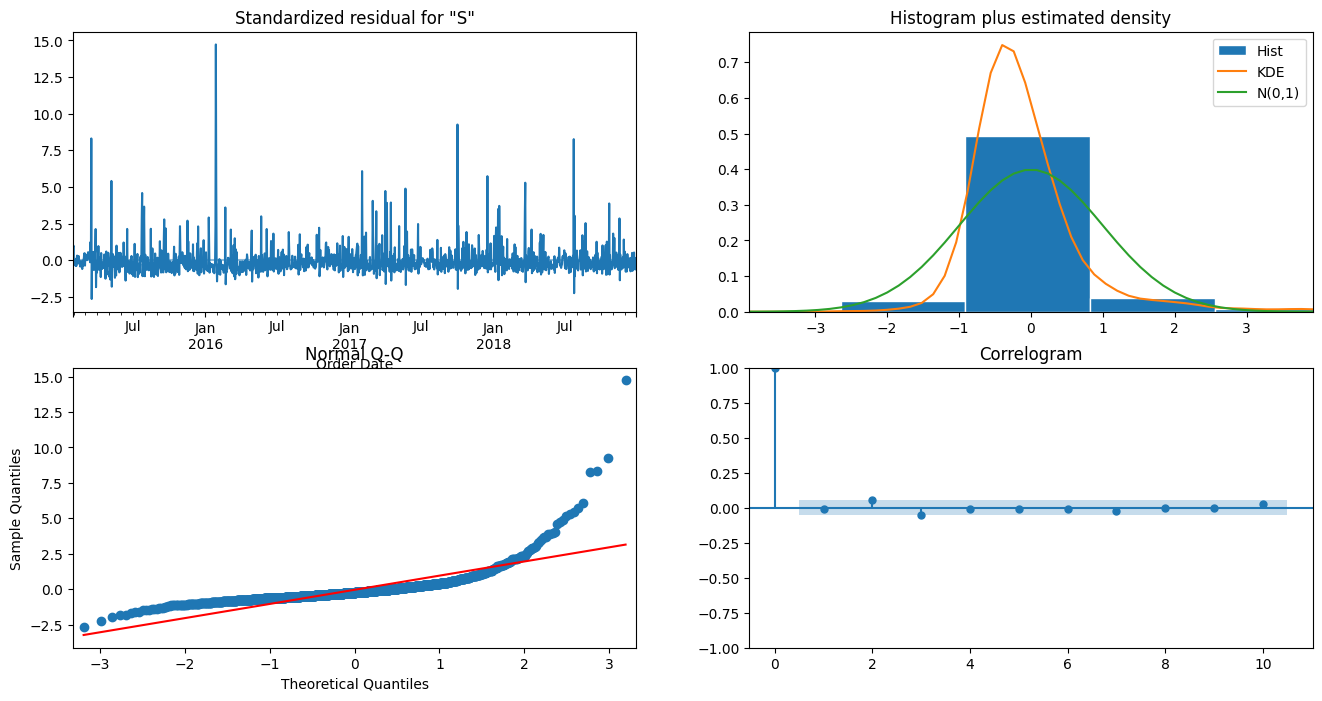

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
# Produces a plot grid of:
# 1. Standardized residuals over time
# 2. Histogram plus estimated density of standardized residulas and along with a Normal(0,1) density plotted for reference.
# 3. Normal Q-Q plot, with Normal reference line and,
# 4. Correlogram.
plt.show()

This shows that the differences between the observed values and the values predicted by the model gather around zero, indicating not much randomness, but with some outliers.

The histogram shows normal distribution of the residuals based on mean and standard deviation.

Normal Q-Q Plot shows that the line roughly follows the curve, confirming the standard deviation.

Correlogram shows the differences over time periods, which does not show significant autocorrelations of the residuals, which the model did not account for. (First value is usually one)

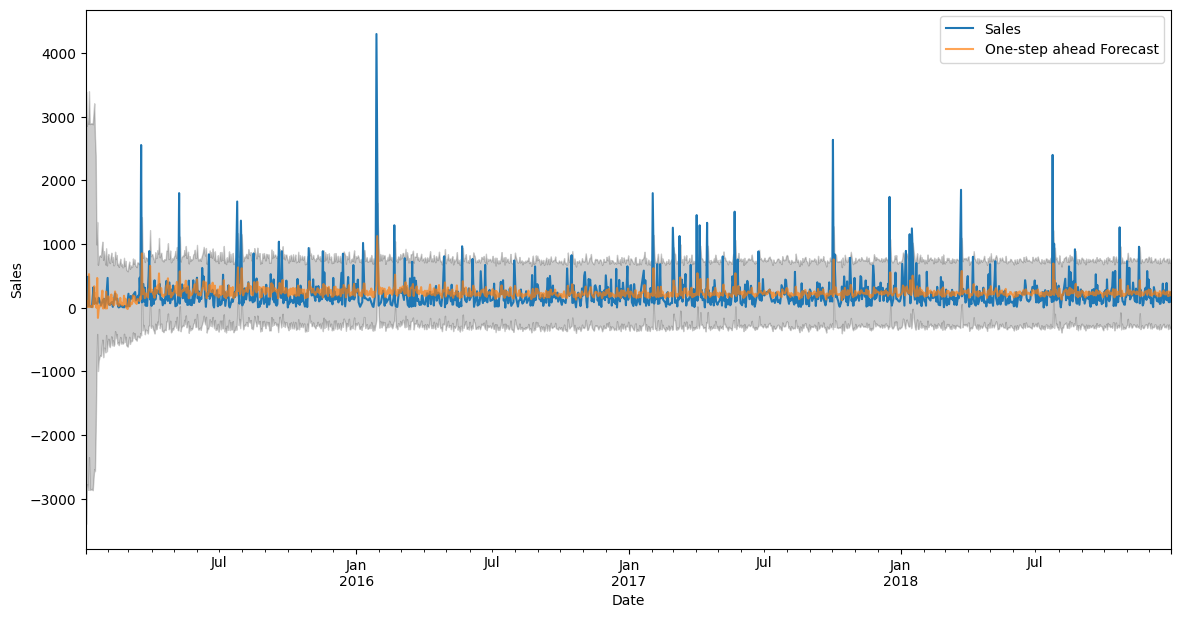

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2015-01-03'), dynamic=False) # variable to display plot for predicted values
pred_val = pred.conf_int()
ax = new_data['2014':].plot(label='observed') # displays plot for original values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7)) # displays plot for predicted values
ax.fill_between(pred_val.index,
                pred_val.iloc[:, 0],
                pred_val.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Calculating errors and making predictions

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = new_data['Sales']

from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(y_forecasted, y_truth)
rmse = sqrt(mse)
print('The Mean Squared Error of the forecasts is {}'.format(round(rmse, 2))) # displays the root mean squared error of the forecast with rounding it up to 2 decimals

The Mean Squared Error of the forecasts is 267.66


In [ ]:
# mod = sm.tsa.statespace.SARIMAX(new_data,
#                                 order=(1, 1, 1),
#                                 seasonal_order=(1, 1, 1, 12),
#                                 enforce_stationarity=False,
#                                 enforce_invertibility=False) #model defintion
# results = mod.fit() #model fitting

forecast = results.forecast(steps=30) # making a forecast of 7 days later of the last date in the 'Order Date' column
print(forecast.astype('int')) #displays the sales forecast as type integer

2018-12-31    229
2019-01-01    241
2019-01-02    244
2019-01-03    229
2019-01-04    196
2019-01-05    254
2019-01-06    223
Freq: D, Name: predicted_mean, dtype: int64


# TIME SERIES WITH PROPHET

In [ ]:
car_sales = pd.read_csv('/content/drive/MyDrive/Coding_data_files/Car_Sales_car_data.csv')
car_sales.head()

Car_id      Date Customer Name Gender  Annual Income  \
0  C_CND_000001  1/2/2022     Geraldine   Male          13500   
1  C_CND_000002  1/2/2022           Gia   Male        1480000   
2  C_CND_000003  1/2/2022        Gianna   Male        1035000   
3  C_CND_000004  1/2/2022       Giselle   Male          13500   
4  C_CND_000005  1/2/2022         Grace   Male        1465000   

                           Dealer_Name   Company       Model  \
0  Buddy Storbeck's Diesel Service Inc      Ford  Expedition   
1                     C & M Motors Inc     Dodge     Durango   
2                          Capitol KIA  Cadillac    Eldorado   
3               Chrysler of Tri-Cities    Toyota      Celica   
4                    Chrysler Plymouth     Acura          TL   

                      Engine Transmission       Color  Price ($)  Dealer_No   \
0  DoubleÂ Overhead Camshaft         Auto       Black      26000  06457-3834   
1  DoubleÂ Overhead Camshaft         Auto       Black      19000  60504-7114   
2          Overhead Camshaft       Manual         Red      31500  38701-8047   
3          Overhead Camshaft       Manual  Pale White      14000  99301-3882   
4  DoubleÂ Overhead Camshaft         Auto         Red      24500  53546-9427   

  Body Style    Phone Dealer_Region  
0        SUV  8264678    Middletown  
1        SUV  6848189        Aurora  
2  Passenger  7298798    Greenville  
3        SUV  6257557         Pasco  
4  Hatchback  7081483    Janesville

In [ ]:
car_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23906 entries, 0 to 23905
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Car_id         23906 non-null  object
 1   Date           23906 non-null  object
 2   Customer Name  23905 non-null  object
 3   Gender         23906 non-null  object
 4   Annual Income  23906 non-null  int64 
 5   Dealer_Name    23906 non-null  object
 6   Company        23906 non-null  object
 7   Model          23906 non-null  object
 8   Engine         23906 non-null  object
 9   Transmission   23906 non-null  object
 10  Color          23906 non-null  object
 11  Price ($)      23906 non-null  int64 
 12  Dealer_No      23906 non-null  object
 13  Body Style     23906 non-null  object
 14  Phone          23906 non-null  int64 
 15  Dealer_Region  23906 non-null  object
dtypes: int64(3), object(13)
memory usage: 2.9+ MB


In [ ]:
car_sales.isnull().sum()

Car_id           0
Date             0
Customer Name    1
Gender           0
Annual Income    0
Dealer_Name      0
Company          0
Model            0
Engine           0
Transmission     0
Color            0
Price ($)        0
Dealer_No        0
Body Style       0
Phone            0
Dealer_Region    0
dtype: int64

In [ ]:
car_sales['Date'].describe()

count        23906
unique         612
top       9/5/2023
freq           190
Name: Date, dtype: object

# EDA and data visualizations

In [ ]:
total_sales = car_sales.groupby('Date')['Price ($)'].sum().sort_values(ascending=False)
total_sales = total_sales.reset_index()
total_sales.head()

Date  Price ($)
0 2023-05-09    5280696
1 2023-10-11    4596334
2 2023-12-29    4430666
3 2023-11-12    4099733
4 2022-08-11    3968329

In [ ]:
car_sales.drop('Car_id', axis=1)
top_company = car_sales.groupby('Company')['Price ($)'].sum().sort_values(ascending=False).head(10)
top_company = top_company.reset_index()
top_company

Company  Price ($)
0   Chevrolet   47655265
1        Ford   47231583
2       Dodge   44124996
3  Oldsmobile   35434512
4  Mercedes-B   34624123
5  Volkswagen   34082881
6  Mitsubishi   34062466
7      Toyota   32759564
8    Chrysler   29141873
9       Lexus   27287703

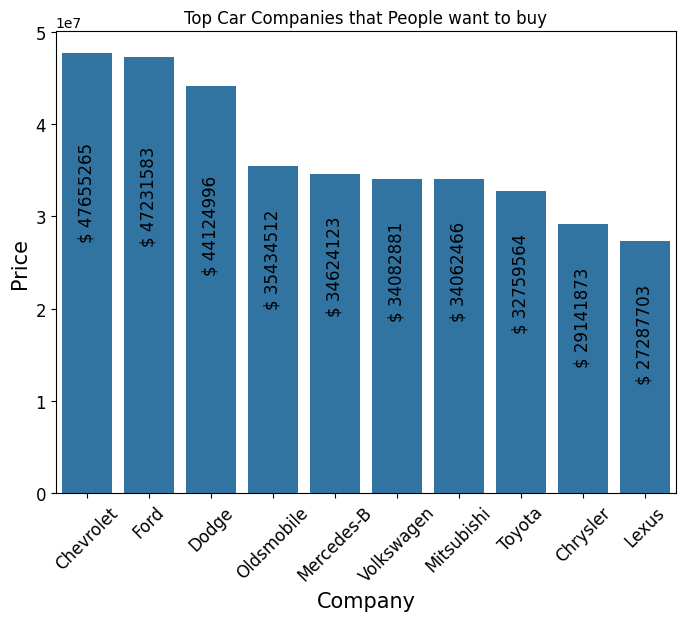

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Top Car Companies that People want to buy')
sns.barplot(data= top_company, x= 'Company', y='Price ($)')
plt.xlabel('Company', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
for k,v in top_company['Price ($)'].items():
  if v > 40000000:
    plt.text(k,v-20000000, '$ ' + str(v), fontsize=12, color='k', rotation=90, horizontalalignment='center')
  else:
    plt.text(k,v-15000000, '$ ' + str(v), fontsize=12, color='k', rotation=90, horizontalalignment='center')

In [ ]:
car_sales['Body Style'].value_counts(), car_sales['Transmission'].value_counts()

(Body Style
 SUV          6374
 Hatchback    6128
 Sedan        4488
 Passenger    3945
 Hardtop      2971
 Name: count, dtype: int64,
 Transmission
 Auto      12571
 Manual    11335
 Name: count, dtype: int64)

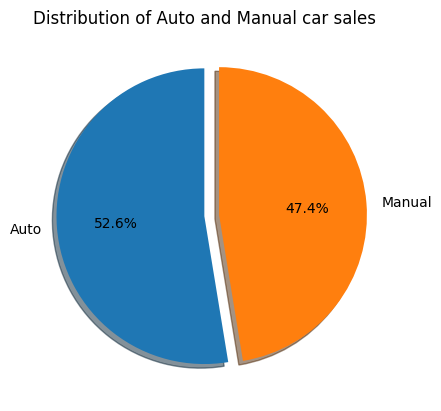

In [ ]:
explode = (0, 0.1)
fig, ax = plt.subplots()
plt.title('Distribution of Auto and Manual car sales')
ax.pie(car_sales['Transmission'].value_counts(), explode=explode, labels=car_sales['Transmission'].unique(), autopct='%1.1f%%',
       shadow=True, startangle=90)
plt.show()

In [ ]:
top_car_style = car_sales.groupby(['Company', 'Body Style'])['Price ($)'].sum().sort_values(ascending=False).head(10)
top_car_style = top_car_style.reset_index()
top_car_style

Company Body Style  Price ($)
0  Oldsmobile      Sedan   19278361
1       Dodge        SUV   16886391
2   Chevrolet        SUV   15836227
3       Lexus      Sedan   14263424
4        Ford        SUV   13829200
5        Ford  Hatchback   13360218
6  Volkswagen  Passenger   12287736
7  Mercedes-B        SUV   11871956
8  Mitsubishi  Hatchback   11182367
9   Chevrolet    Hardtop   11168717

<Axes: >

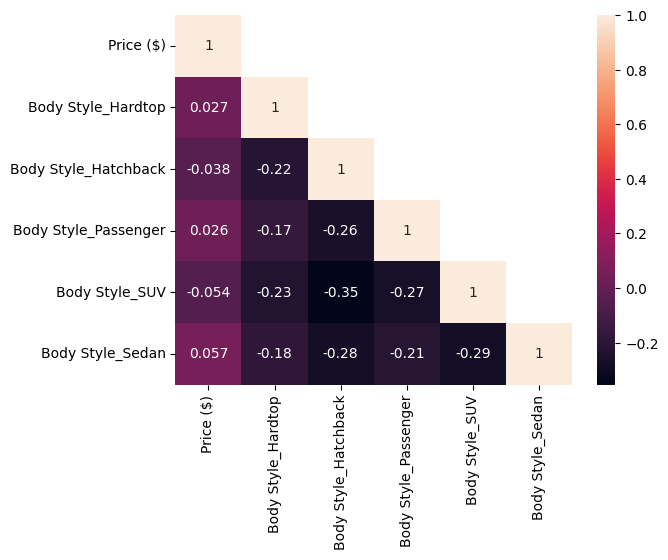

In [ ]:
df1 = car_sales[['Body Style', 'Price ($)']]
df_cat = pd.get_dummies(df1)
cor_mat = df_cat.corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)]=False
sns.heatmap(df_cat.corr(), annot=True, cbar=True, mask=mask)

In [ ]:
top_customer = car_sales.groupby('Customer Name')['Price ($)'].sum().sort_values(ascending=False).head(10)
top_customer = top_customer.reset_index()
top_customer

Customer Name  Price ($)
0          Emma    2796875
1         Lucas    2637188
2        Thomas    2547478
3        Alexis    2190772
4           Lea    2129534
5         Chloe    2028568
6        Nathan    2013534
7          Paul    1978928
8          Hugo    1929031
9         Louis    1834775

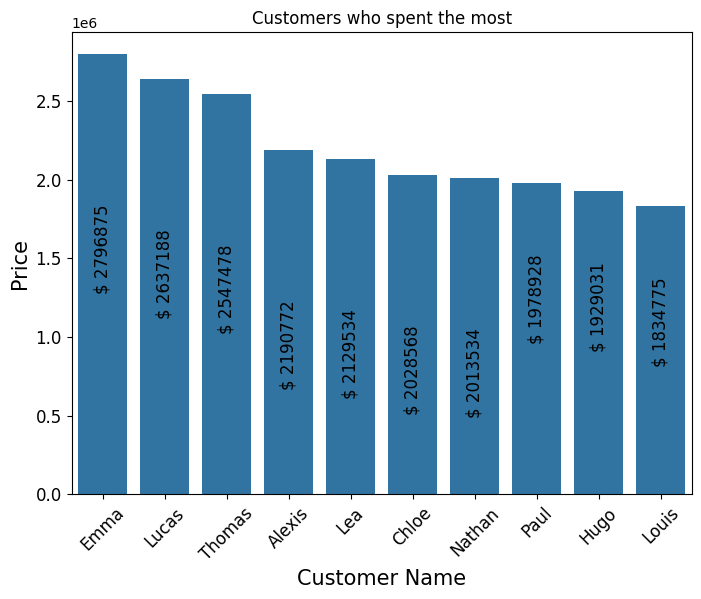

In [ ]:
plt.figure(figsize=(8,6))
plt.title('Customers who spent the most')
sns.barplot(data= top_customer, x= 'Customer Name', y='Price ($)')
plt.xlabel('Customer Name', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
for k,v in top_customer['Price ($)'].items():
  if v > 2000000:
    plt.text(k,v-1500000, '$ ' + str(v), fontsize=12, color='k', rotation=90, horizontalalignment='center')
  else:
    plt.text(k,v-1000000, '$ ' + str(v), fontsize=12, color='k', rotation=90, horizontalalignment='center')

# Preparing for time-series prediction

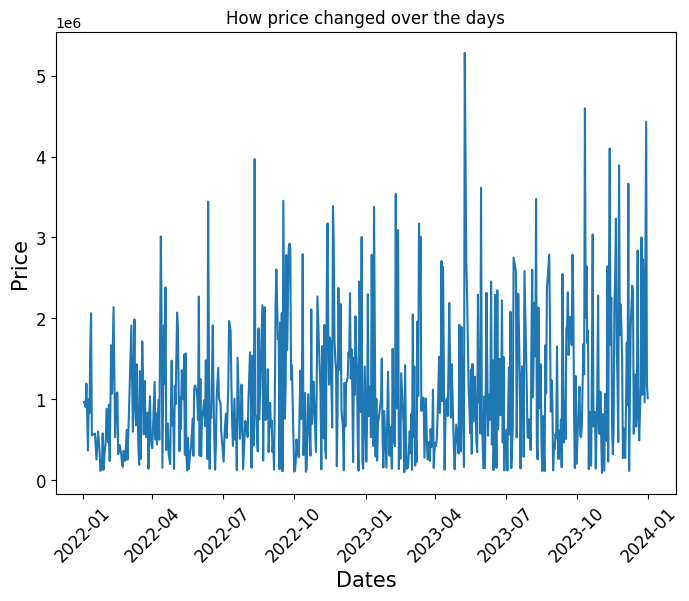

In [ ]:
plt.figure(figsize=(8,6))
plt.title('How price changed over the days')
sns.lineplot(data= total_sales, x= 'Date', y='Price ($)')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

total_sales = total_sales.set_index('Date')

adf = adfuller(total_sales)

print('\nADF = ', str(adf[0]))
print('\np-value = ', str(adf[1]))
print('\nCritical Values: ')

for key, val in adf[4].items():
    print(key,':',val)


    if adf[0] < val:
        print('Null Hypothesis Rejected. Time Series is Stationary')
    else:
        print('Null Hypothesis Accepted. Time Series is not Stationary')


ADF =  -5.096020514167383

p-value =  1.4279609086831817e-05

Critical Values: 
1% : -3.441444394224128
Null Hypothesis Rejected. Time Series is Stationary
5% : -2.8664345376276454
Null Hypothesis Rejected. Time Series is Stationary
10% : -2.569376663737217
Null Hypothesis Rejected. Time Series is Stationary


In [ ]:
total_sales = total_sales.reset_index()

In [ ]:
fc_model = car_sales[['Date','Price ($)']]

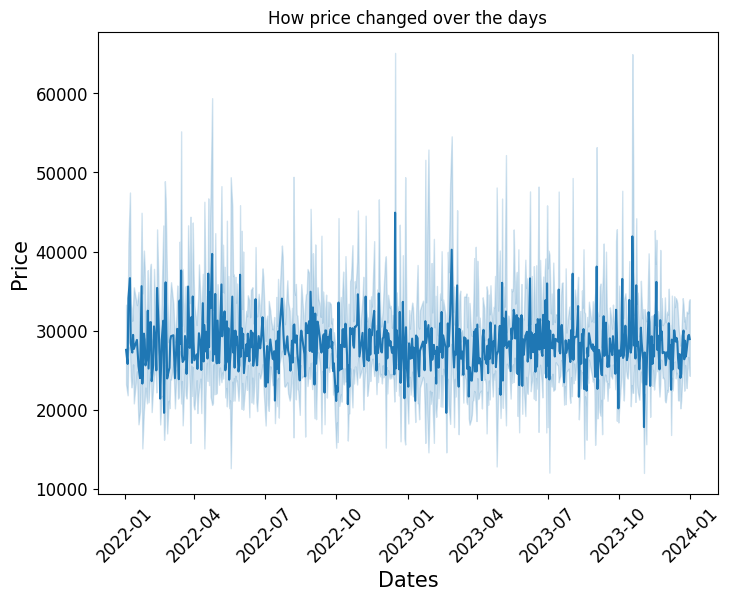

In [ ]:
plt.figure(figsize=(8,6))
plt.title('How price changed over the days')
sns.lineplot(data= fc_model, x= 'Date', y='Price ($)')
plt.xlabel('Dates', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
train_sales = fc_model[fc_model['Date'] < '2023-07']
test_sales = fc_model[fc_model['Date'] >= '2023-07']

train_sales.shape, test_sales.shape

((16280, 2), (7626, 2))

In [ ]:
train_sales.head()

Date  Price ($)
0 2022-02-01      26000
1 2022-02-01      19000
2 2022-02-01      31500
3 2022-02-01      14000
4 2022-02-01      24500

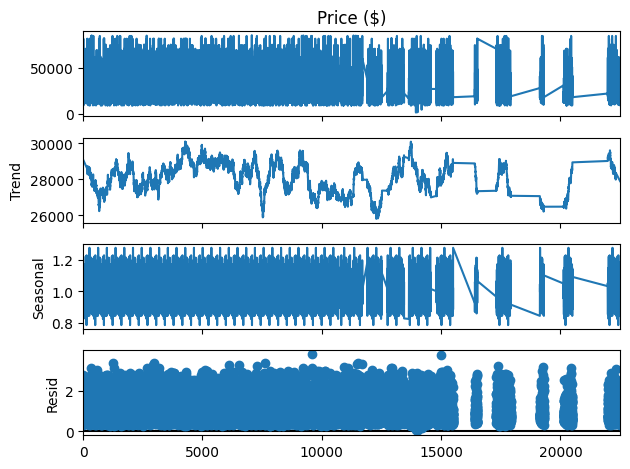

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(train_sales['Price ($)'], model='multiplicative', extrapolate_trend='freq', period=365)

decompose.plot().show()

In [ ]:
df_train_prophet = train_sales

# date variable needs to be named "ds" for prophet
df_train_prophet = df_train_prophet.rename(columns={"Date": "ds"})

# target variable needs to be named "y" for prophet
df_train_prophet = df_train_prophet.rename(columns={"Price ($)": "y"})

In [ ]:
from prophet import Prophet
model_prophet  = Prophet()
model_prophet.fit(df_train_prophet)

df_future = model_prophet.make_future_dataframe(periods=30, freq='MS')
display(df_future)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaw7dknx1/ht8jx3bf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpaw7dknx1/t_h_67uz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41103', 'data', 'file=/tmp/tmpaw7dknx1/ht8jx3bf.json', 'init=/tmp/tmpaw7dknx1/t_h_67uz.json', 'output', 'file=/tmp/tmpaw7dknx1/prophet_modeldhf1pm9z/prophet_model-20250502200659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:06:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:07:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
0   2022-01-03
1   2022-01-05
2   2022-01-06
3   2022-01-08
4   2022-01-09
..         ...
471 2025-08-01
472 2025-09-01
473 2025-10-01
474 2025-11-01
475 2025-12-01

[476 rows x 1 columns]

In [ ]:
forecast_prophet = model_prophet.predict(df_future)
forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()
# Prediction interpretation:
# yhat: sales in the month
# yhat_lower: min sales predicted for the month
# yhat_upper: max sales predicted for the month

ds     yhat  yhat_lower  yhat_upper
471 2025-08-01  36303.0     17209.0     55127.0
472 2025-09-01  36343.0     18652.0     56315.0
473 2025-10-01  37035.0     18223.0     56196.0
474 2025-11-01  36655.0     17605.0     56083.0
475 2025-12-01  37255.0     17240.0     56418.0

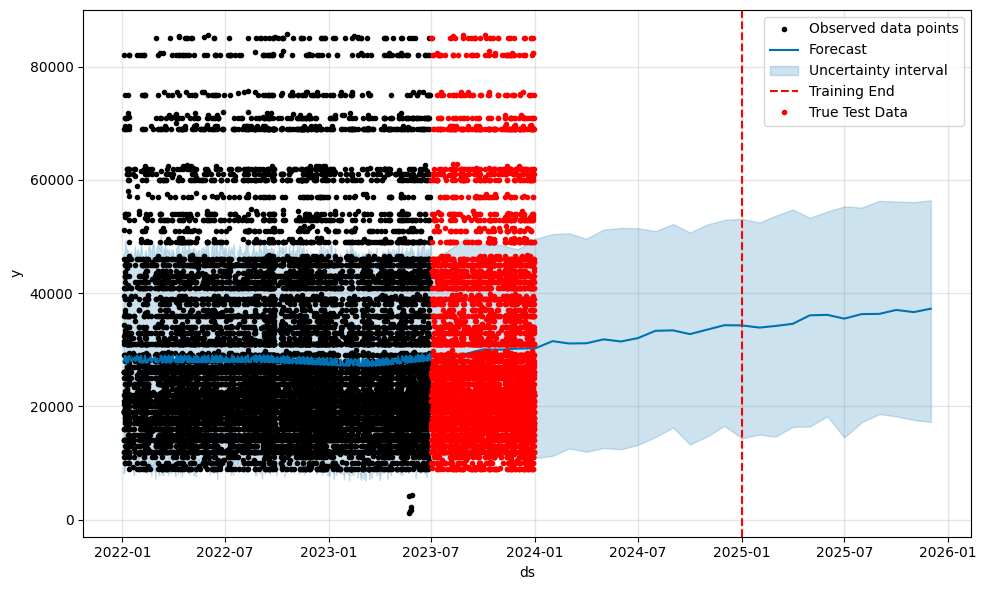

In [ ]:
# plot the time series
forecast_plot = model_prophet.plot(forecast_prophet)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
last_training_date = forecast_prophet['ds'].iloc[-12]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line
# test_sales['Date'] = pd.to_datetime(test_sales['Date'])
plt.plot(test_sales['Date'], test_sales['Price ($)'],'ro', markersize=3, label='True Test Data')

# show the legend to distinguish between the lines
plt.legend()

# TIME SERIES ANALYSIS WITH LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [ ]:
wal_sales = pd.read_csv('/content/drive/MyDrive/Coding_data_files/Walmart_sales/train.csv')
wal_sales.head()

Store  Dept        Date  Weekly_Sales  IsHoliday
0      1     1  2010-02-05      24924.50      False
1      1     1  2010-02-12      46039.49       True
2      1     1  2010-02-19      41595.55      False
3      1     1  2010-02-26      19403.54      False
4      1     1  2010-03-05      21827.90      False

In [ ]:
wal_sales.shape

(421570, 5)

Checking the changes of sales over all stores per week.

<Axes: >

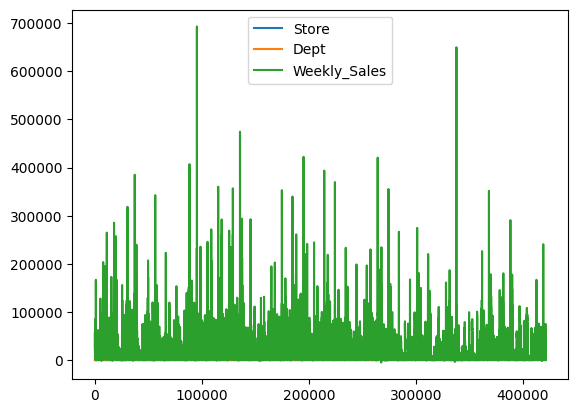

In [ ]:
wal_sales.plot()

In [ ]:
wal_stores = pd.read_csv('/content/drive/MyDrive/Coding_data_files/Walmart_sales/stores.csv')
wal_stores.head()

Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875

Merging the datasets to be able to include the size of store as possible factors for reaching certain number of sales per week.

In [ ]:
wal_sales = pd.merge(
    wal_sales,
    wal_stores,
    on='Store',
    how='left'
)

In [ ]:
wal_sales.head(), wal_sales.shape

(   Store  Dept        Date  Weekly_Sales  IsHoliday Type    Size
 0      1     1  2010-02-05      24924.50      False    A  151315
 1      1     1  2010-02-12      46039.49       True    A  151315
 2      1     1  2010-02-19      41595.55      False    A  151315
 3      1     1  2010-02-26      19403.54      False    A  151315
 4      1     1  2010-03-05      21827.90      False    A  151315,
 (421570, 7))

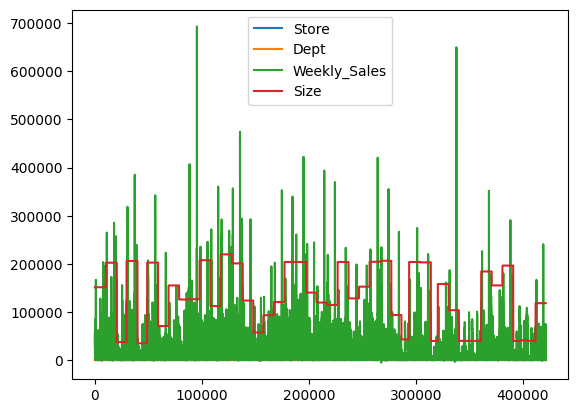

In [ ]:
wal_sales.plot()
plt.show()

In [ ]:
wal_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
dtypes: bool(1), float64(1), int64(3), object(2)
memory usage: 19.7+ MB


In [ ]:
wal_sales.isnull().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Type            0
Size            0
dtype: int64

In [ ]:
wal_sales['Date'] = pd.to_datetime(wal_sales['Date'])

Separating the different stores to be able to predict their sales one by one.

In [ ]:
feature_store_a = wal_sales[wal_sales['Type'] == 'A']
feature_store_b = wal_sales[wal_sales['Type'] == 'B']
feature_store_c = wal_sales[wal_sales['Type'] == 'C']

In [ ]:
feature_store_a.shape[0], feature_store_b.shape[0], feature_store_c.shape[0]

(215478, 163495, 42597)

In [ ]:
features_a = feature_store_a.drop(['Store', 'Dept', 'Type'], axis=1)
# target_col_a = feature_store_a['Weekly_Sales']
features_a = features_a.set_index('Date')

features_b = feature_store_b.drop(['Store', 'Dept', 'Type'], axis=1)
# target_col_b = feature_store_b['Weekly_Sales']
features_b = features_b.set_index('Date')

features_c = feature_store_c.drop(['Store', 'Dept', 'Type'], axis=1)
# target_col_c = feature_store_c['Weekly_Sales']
features_c = features_c.set_index('Date')

In [ ]:
features_a_data = features_a.values
features_b_data = features_b.values
features_c_data = features_c.values

In [ ]:
tf.random.set_seed(15)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features_a_data)

In [ ]:
# splitting dataset

train_ratio = 0.8
val_ratio = 0.2

train_size = int(len(features_a_data) * train_ratio)
val_size = len(features_a_data) - train_size

In [ ]:
features_a_col = features_a.columns
sales_index = features_a[:, 'Weekly_Sales']
features_a_col

InvalidIndexError: (slice(None, None, None), 'Weekly_Sales')

In [ ]:
# function to create new dataset with 'look-back'

look_back = 12
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    # Find the index of the sales column within the selected feature_columns
    # correct method to find the position of a label in an Index is .get_loc()
    sales_index = features_a_col.get_loc('Weekly_Sales')

    for i in range(len(dataset) - look_back):
        # Get the sequence of 'look_back' time steps for all features
        sequence = dataset[i:(i + look_back), :] # Select all columns for the sequence
        X.append(sequence)
        # Get the target value (sales) for the next time step
        Y.append(dataset[i + look_back, sales_index]) # Select only the sales value

    return np.array(X), np.array(Y)

X, y = create_dataset(scaled_data, look_back)

In [ ]:
# prepare the train and test datasets for modeling

X_train, X_val = X[0:train_size,:], X[train_size:len(X),:]
y_train, y_val = y[0:train_size], y[train_size:len(y)]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(features_a_col)))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], len(features_a_col)))

num_features = len(features_a_col)

In [ ]:
# build the model

model = Sequential()
# Add an LSTM layer. Input shape is (time steps, features)
model.add(LSTM(50, input_shape=(look_back, num_features))) # Input shape now includes num_features
# Optional: Add Dropout for regularization to prevent overfitting
# model.add(Dropout(0.2))
# Add a Dense output layer with 1 unit (for predicting the next sales value)
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam') # MSE is common for regression tasks

# Print the model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,851 (42.39 KB)

 Trainable params: 10,851 (42.39 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the LSTM network

print("\nTraining the LSTM model with validation...")
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=1,
                    verbose=2,
                    validation_data=(X_val, y_val)) # Use validation data
print("Model training complete.")


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

**In the followings, the model can be tested on the test dataset and replicated to the other stores**